# Компьютер говорит "Нет"

In [1]:
import random
from statsmodels.stats.multitest import multipletests
import os.path
import pandas_profiling
from scipy import stats
import itertools as it
from collections import Counter
from datetime import datetime, timedelta
import re
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score
from sklearn.metrics import f1_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn import preprocessing
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.base import BaseEstimator
from sklearn import pipeline
from pandas import Series
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier


import copy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Задача
Построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого нужно будет определить значимые параметры заемщика.

## Данные
### Предоставлена информация из анкетных данных заемщиков и факт наличия дефолта.

| Признак | Описание |
| :--- | :--- | 
| client_id | идентификатор клиента |
| education | уровень образования |
| sex | пол заёмщика |
| age | возраст заёмщика |
| car | флаг наличия автомобиля |
| car_type | флаг автомобиля-иномарки |
| decline_app_cnt | количество отказанных прошлых заявок |
| good_work | флаг наличия «хорошей» работы |
| bki_request_cnt | количество запросов в БКИ |
| home_address | категоризатор домашнего адреса |
| work_address | категоризатор рабочего адреса |
| income | доход заёмщика |
| foreign_passport | наличие загранпаспорта |
| sna | связь заемщика с клиентами банка |
| first_time | давность наличия информации о заемщике |
| score_bki | скоринговый балл по данным из БКИ |
| region_rating | рейтинг региона |
| app_date | дата подачи заявки |
| default | наличие дефолта |

### Посмотрим на данные
<a id='load_data'></a>

In [2]:
DATA_PATH='.'

In [3]:
train = pd.read_csv(DATA_PATH + '/train.csv')
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [4]:
# Дата представлена в формате %d%b%Y - сразу переведем в тип datetime
train['app_date'] = pd.to_datetime(train['app_date'])

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   client_id         73799 non-null  int64         
 1   app_date          73799 non-null  datetime64[ns]
 2   education         73492 non-null  object        
 3   sex               73799 non-null  object        
 4   age               73799 non-null  int64         
 5   car               73799 non-null  object        
 6   car_type          73799 non-null  object        
 7   decline_app_cnt   73799 non-null  int64         
 8   good_work         73799 non-null  int64         
 9   score_bki         73799 non-null  float64       
 10  bki_request_cnt   73799 non-null  int64         
 11  region_rating     73799 non-null  int64         
 12  home_address      73799 non-null  int64         
 13  work_address      73799 non-null  int64         
 14  income            7379

In [6]:
train.describe(datetime_is_numeric=True).transpose()

,count,mean,min,25%,50%,75%,max,std
client_id,73799.0,55137.965094,1.0,27440.5,55274.0,82758.5,110147.0,31841.921168
app_date,73799,2014-03-03 00:51:01.504898816,2014-01-01 00:00:00,2014-02-03 00:00:00,2014-03-04 00:00:00,2014-03-31 00:00:00,2014-04-30 00:00:00,NaN
age,73799.0,39.280641,21.0,30.0,37.0,48.0,72.0,11.520378
decline_app_cnt,73799.0,0.275749,0.0,0.0,0.0,0.0,33.0,0.804272
good_work,73799.0,0.164894,0.0,0.0,0.0,0.0,1.0,0.371087
score_bki,73799.0,-1.904724,-3.624586,-2.259534,-1.920823,-1.569831,0.199773,0.498231
bki_request_cnt,73799.0,2.000339,0.0,0.0,1.0,3.0,53.0,2.252073
region_rating,73799.0,56.725701,20.0,50.0,50.0,60.0,80.0,13.055717
home_address,73799.0,1.575509,1.0,1.0,2.0,2.0,3.0,0.527631
work_address,73799.0,2.49628,1.0,2.0,3.0,3.0,3.0,0.689818


In [7]:
train.describe(exclude=[np.number, np.datetime64],
               datetime_is_numeric=True).transpose()

,count,unique,top,freq
education,73492,5,SCH,38860
sex,73799,2,F,41562
car,73799,2,N,49832
car_type,73799,2,N,59791
foreign_passport,73799,2,N,62733


##### Промежуточные выводы
Данные представлены за период с 2014-01-01 по 2014-04-30, кол-во записей - 73799, только столбец education имеет пропуски.

## EDA
<a id='eda'></a>
[Goto data load](#load_data)

### Для начала поробуем pandas_profiling

In [8]:
# для того, чтобы предотвратить повторный вызов профайлера, проверим наличие результатов его работы
if not os.path.exists('eda_profiling.html'):
    profile = pandas_profiling.ProfileReport(
        train, title='Credit scoring profiler report', explorative=True)
    profile.to_file('eda_profiling.html')

[EDA profiling output](eda_profiling.html)

##### Промежуточные выводы
* client_id - полностью уникальный идентификатор - исключить
* education - имеет пропуски (307, <0.1%) - заменить пропуски на UNK
* age - имеется несколько экстремально старых клиентов, распределение скошено влево - изучить подробнее
* car и car_type - посмотреть есть ли записи с car=N и car_type=Y (не может быть), так же обнаружена корреляция крамера для этх признаков
* decline_app_cnt - имеются клиенты с количеством отказов больше 20 - изучить подробнее
* bki_request_cnt - имеются записи с экстремально большими значениями - изучить подробнее
* income - имеется несколько клиентов с очень большим и очень маленьким доходом, распределение сильно скошено влево - log и изучить подробнее


In [9]:
def outliers(df, feature):
    # Интерквартильный размах
    perc25 = df[feature].quantile(0.25)
    perc75 = df[feature].quantile(0.75)
    IQR = perc75 - perc25
    low, high = (perc25 - 1.5 * IQR, perc75 + 1.5 * IQR)
    print(
        f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR}, Границы выбросов: [{low}, {high}]')
    return df[(df[feature] < low) | (df[feature] > high)]


def get_stat_dif(df, feature, target, dropna=True, check=True, alpha=0.5):
    cols = df.loc[:, feature].value_counts(dropna=dropna).index
    combinations_all = list(it.combinations(cols, 2))
    p_values = []
    p_combs = []
    bonferony = []
    for comb in combinations_all:
        len0 = len(df.loc[df.loc[:, feature] == comb[0]])
        len1 = len(df.loc[df.loc[:, feature] == comb[1]])
        if check and len(df.loc[df.loc[:, feature] == comb[0]]) < 30:
            msg = 'Количество значений {} ({}) = {} (<30) тест стьюдента может дать некорректные результаты'.format(
                feature, comb[0], len0)
#            raise Exception(msg)
            continue
        if check and len(df.loc[df.loc[:, feature] == comb[1]]) < 30:
            msg = 'Количество значений {} ({}) = {} (<30) тест стьюдента может дать некорректные результаты'.format(
                feature, comb[1], len1)
#            raise Exception(msg)
            continue
        res = stats.ttest_ind(df.loc[df.loc[:, feature] == comb[0], target],
                              df.loc[df.loc[:, feature] == comb[1], target])
        p_combs.append(comb)
        p_values.append(res.pvalue)
        # Учли поправку Бонферони
        if res.pvalue <= alpha / len(combinations_all):
            print(
                f'Найдены статистически значимые различия для {feature} (поправка Бонферони)  комбинация {comb} p-value {res.pvalue}')
            bonferony.append(comb)

    res = multipletests(p_values, alpha=alpha, method='holm-sidak')
    rejected = []
    for i in range(0, len(res[0])):
        if res[0][i] == True:  # Гипотеза отвергается
            #            print(f'Найдены статистически значимые различия для {feature} (поправка Холм-Сидака)  комбинация {p_combs[i]} p-value {p_values[i]}')
            #            print(p_combs[i], p_values[i], res[0][i])
            rejected.append(p_combs[i])
    return (rejected, bonferony)

### Age

25-й перцентиль: 30.0, 75-й перцентиль: 48.0, IQR: 18.0, Границы выбросов: [3.0, 75.0]


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default


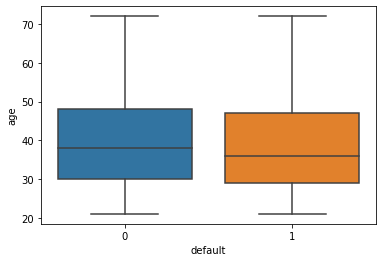

In [10]:
display(outliers(train, 'age'))
_ = sns.boxplot(x='default', y='age', data=train)

In [11]:
# Вроде выбросов нет - оставляем

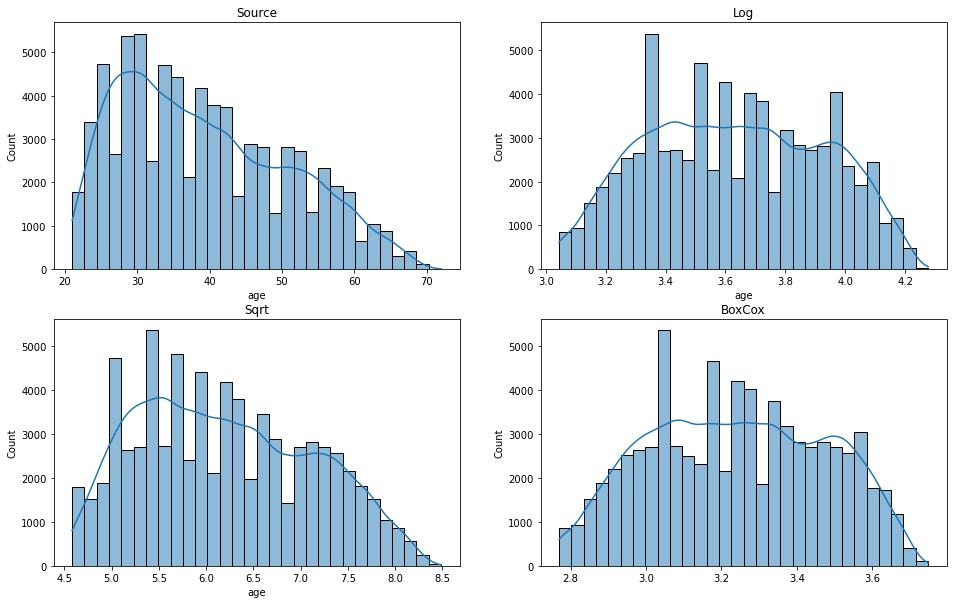

In [12]:
# У age большой правый хвост - попробуем исправить 
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16, 10)
ax[0][0].set_title('Source')
_ = sns.histplot(train['age'], fill=True, kde=True, bins=30, ax=ax[0][0])
ax[0][1].set_title('Log')
_ = sns.histplot(np.log(train['age']), fill=True, kde=True, bins=30, ax=ax[0][1])
ax[1][0].set_title('Sqrt')
_ = sns.histplot(np.sqrt(train['age']), fill=True, kde=True, bins=30, ax=ax[1][0])
ax[1][1].set_title('BoxCox')
_ = sns.histplot(stats.boxcox(train['age'])[0], fill=True, kde=True, bins=30, ax=ax[1][1])


In [13]:
print('normality =', stats.normaltest(np.log(train['age'])))
stat, p = stats.shapiro(train['age'].sample(5000)) # тест Шапиро-Уилк
print('Шапиро-Уилк = Statistics=%.3f, p-value=%.10f' % (stat, p))

normality = NormaltestResult(statistic=15613.197409088569, pvalue=0.0)
Шапиро-Уилк = Statistics=0.957, p-value=0.0000000000


In [14]:
# После логарифмирования стало больше похоже на нормальное, но все равно далеко от него

### Car и car_type

In [15]:
train[(train['car'] == 'N') & (train['car_type'] == 'Y')]
# Клиентов у которых нет машины и одновременно есть иномарка нет - не все в порядке

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default


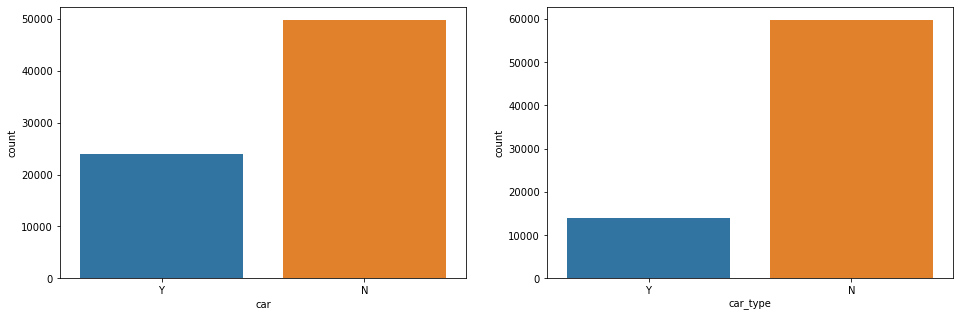

In [16]:
plt.figure(figsize=(16, 5))
plt.subplot(121)
_ = sns.countplot(x='car', data=train)
plt.subplot(122)
_ = sns.countplot(x='car_type', data=train)

In [17]:
# Посмотрим на числовые значения корреляции
temp = train[['car', 'car_type']].copy()
temp['car'] = LabelEncoder().fit_transform(temp['car'])
temp['car_type'] = LabelEncoder().fit_transform(temp['car_type'])
temp.corr()

,car,car_type
car,1.000000,0.697939
car_type,0.697939,1.000000


### Decline_app_cnt

25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0, Границы выбросов: [0.0, 0.0]


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
8,38424,2014-02-14,SCH,F,50,Y,N,1,0,-1.676061,0,50,1,1,30000,1,4,N,0
10,26995,2014-02-03,UGR,M,50,Y,N,2,0,-1.700105,1,80,2,3,60000,1,4,Y,0
33,24303,2014-01-31,UGR,M,26,N,N,2,0,-1.109779,1,80,2,3,70000,1,4,Y,0
38,74699,2014-03-22,GRD,F,26,N,N,1,0,-1.240889,0,80,1,3,26000,1,3,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73757,31552,2014-02-07,SCH,M,37,Y,N,2,0,-2.377837,2,70,2,3,28000,1,2,N,0
73762,84655,2014-04-01,SCH,F,49,N,N,1,0,-2.615974,2,50,2,3,15000,4,2,N,0
73771,71933,2014-03-19,SCH,F,31,N,N,3,0,-1.212728,12,50,1,1,70000,1,3,Y,0
73776,104725,2014-04-23,UGR,M,30,N,N,4,0,-1.600018,1,50,2,3,32000,4,2,N,0


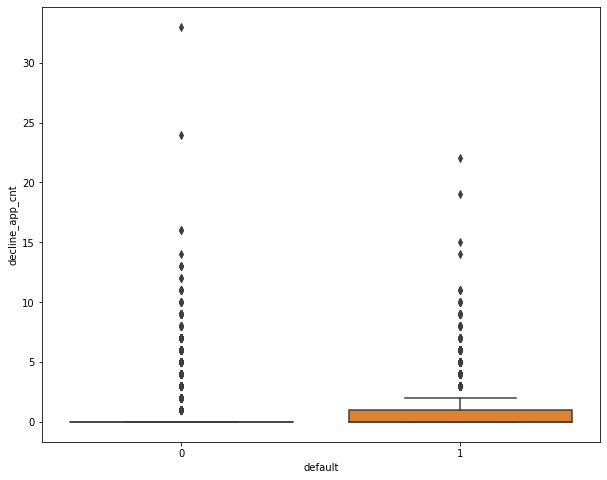

In [18]:
display(outliers(train, 'decline_app_cnt'))
plt.figure(figsize=(10, 8))
_ = sns.boxplot(x='default', y='decline_app_cnt', data=train)

In [19]:
# Очень много нулевых значений приводит к тому что все остальные помечаются как выбросы

<AxesSubplot:>

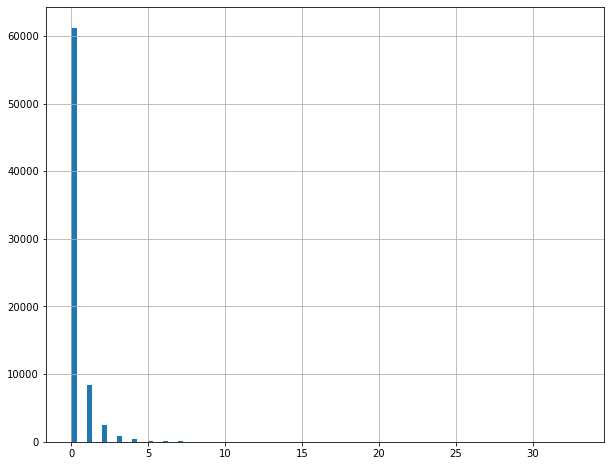

In [20]:
plt.figure(figsize=(10, 8))
train['decline_app_cnt'].hist(bins=100)

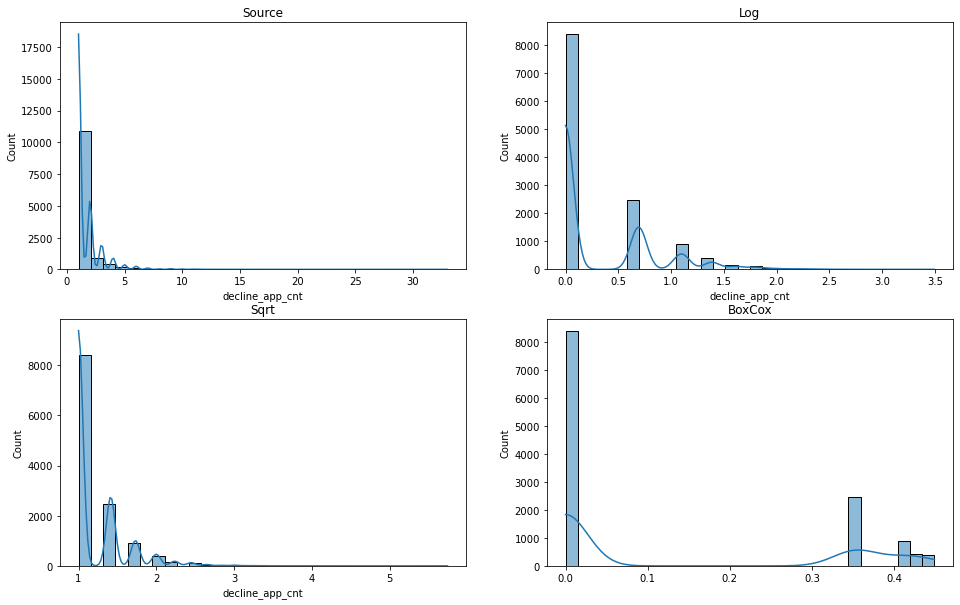

In [21]:
# У age большой правый хвост - попробуем исправить 
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16, 10)
indices = train['decline_app_cnt'] > 0
ax[0][0].set_title('Source')
_ = sns.histplot(train.loc[indices, 'decline_app_cnt'], fill=True, kde=True, bins=30, ax=ax[0][0])
ax[0][1].set_title('Log')
_ = sns.histplot(np.log(train.loc[indices, 'decline_app_cnt']), fill=True, kde=True, bins=30, ax=ax[0][1])
ax[1][0].set_title('Sqrt')
_ = sns.histplot(np.sqrt(train.loc[indices, 'decline_app_cnt']), fill=True, kde=True, bins=30, ax=ax[1][0])
ax[1][1].set_title('BoxCox')
_ = sns.histplot(stats.boxcox(train.loc[indices, 'decline_app_cnt'])[0], fill=True, kde=True, bins=30, ax=ax[1][1])

In [22]:
# После преобразований лучше не стало

In [23]:
# Посмотрим есть ли влияние этих признаков на целевую переменную
f, p = f_classif(train[['decline_app_cnt']], train['default'])
print(f'F-statistic = {f[0]}, p-value = {p[0]}')

F-statistic = 966.2069748841786, p-value = 9.209168013654577e-211


<AxesSubplot:>

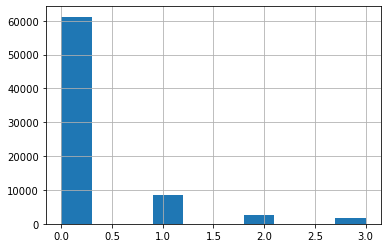

In [24]:
# Можно попробовать сгруппировать отказы 0, 1, 2, >2
temp = train['decline_app_cnt'].apply(
    lambda x: 0 if x == 0 else 1 if x == 1 else 2 if x == 2 else 3)
#_ = sns.countplot(data=temp)
temp.hist()

### Home_address и work_address

<AxesSubplot:>

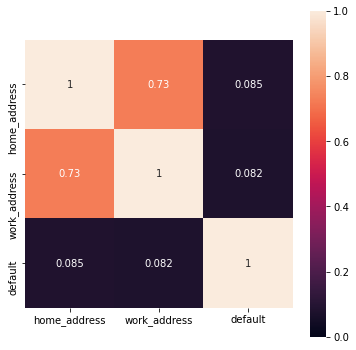

In [25]:
# В профайлере обнаружена корреляция между нome_address и work_address, посмотрим подробнее
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(train[['home_address', 'work_address', 'default']].corr().abs(), vmin=0, vmax=1, annot=True, square=True)

In [26]:
# Возможно следует исключить work_address ?

### Bki_request_cnt

25-й перцентиль: 0.0, 75-й перцентиль: 3.0, IQR: 3.0, Границы выбросов: [-4.5, 7.5]


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
54,24780,2014-01-31,GRD,F,36,Y,Y,0,0,-1.801896,8,60,1,1,200000,1,3,Y,0
107,63971,2014-03-13,SCH,M,39,Y,Y,0,0,-2.363507,13,80,2,3,65000,1,4,Y,0
114,30379,2014-02-06,UGR,F,39,Y,Y,0,0,-1.461151,8,80,2,3,70000,1,3,Y,0
185,7335,2014-01-14,SCH,F,56,N,N,2,0,-0.908905,13,50,2,3,27000,4,2,N,0
188,109335,2014-04-30,GRD,M,36,Y,Y,0,0,-2.421236,10,60,2,3,75000,2,3,N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73334,49727,2014-02-26,SCH,F,48,N,N,0,0,-1.477164,11,60,2,3,20000,1,3,N,1
73412,56492,2014-03-05,SCH,F,56,N,N,3,0,-0.589186,28,50,1,2,27000,1,4,N,0
73461,2870,2014-01-08,SCH,M,47,N,N,4,0,-1.534407,23,50,1,3,24000,1,4,N,0
73679,61859,2014-03-11,SCH,F,28,N,N,7,0,-2.068988,8,50,3,3,30000,1,3,Y,0


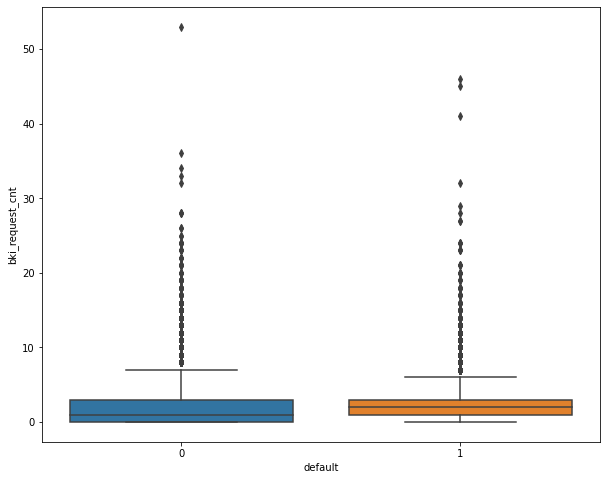

In [27]:
display(outliers(train, 'bki_request_cnt'))
plt.figure(figsize=(10, 8))
_ = sns.boxplot(x='default', y='bki_request_cnt', data=train)

In [28]:
# Очень много нулевых значений приводит к тому что все остальные помечаются как выбросы

In [29]:
# Посмотрим есть ли влияние этих признаков на целевую переменную
f, p = f_classif(train[['bki_request_cnt']], train['default'])
print(f'F-statistic = {f[0]}, p_value = {p[0]}')

F-statistic = 454.55578643415953, p_value = 1.4816351290098387e-100


<AxesSubplot:>

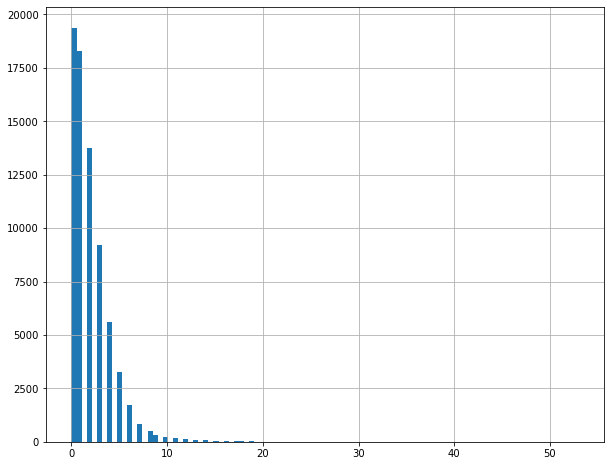

In [30]:
plt.figure(figsize=(10, 8))
train['bki_request_cnt'].hist(bins=100)

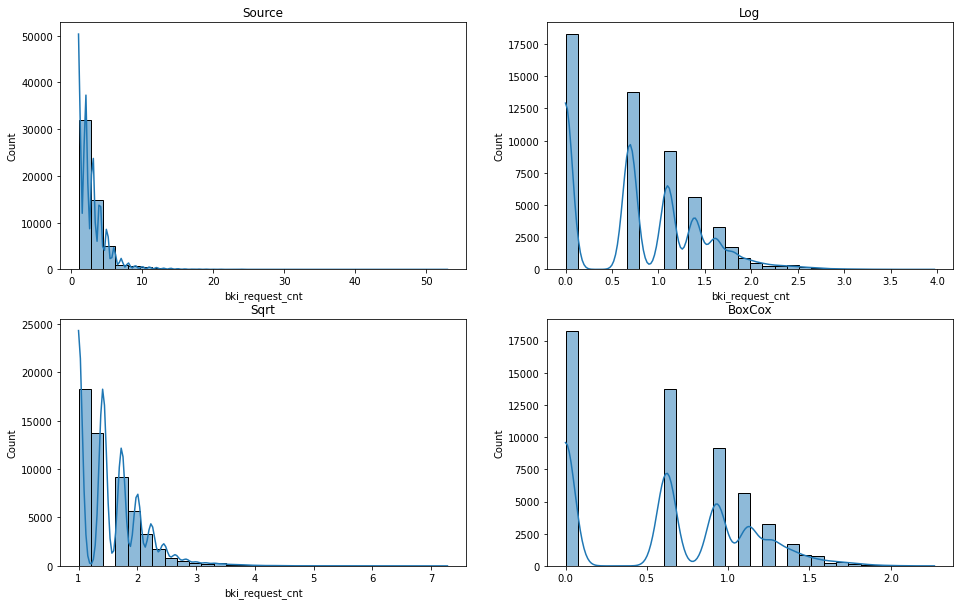

In [31]:
# У признака большой правый хвост - попробуем исправить 
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16, 10)
indices = train['bki_request_cnt'] > 0
ax[0][0].set_title('Source')
_ = sns.histplot(train.loc[indices, 'bki_request_cnt'], fill=True, kde=True, bins=30, ax=ax[0][0])
ax[0][1].set_title('Log')
_ = sns.histplot(np.log(train.loc[indices, 'bki_request_cnt']), fill=True, kde=True, bins=30, ax=ax[0][1])
ax[1][0].set_title('Sqrt')
_ = sns.histplot(np.sqrt(train.loc[indices, 'bki_request_cnt']), fill=True, kde=True, bins=30, ax=ax[1][0])
ax[1][1].set_title('BoxCox')
_ = sns.histplot(stats.boxcox(train.loc[indices, 'bki_request_cnt'])[0], fill=True, kde=True, bins=30, ax=ax[1][1])

In [32]:
# После преобразований лучше не стало

### Region_rating

25-й перцентиль: 50.0, 75-й перцентиль: 60.0, IQR: 10.0, Границы выбросов: [35.0, 75.0]


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
10,26995,2014-02-03,UGR,M,50,Y,N,2,0,-1.700105,1,80,2,3,60000,1,4,Y,0
28,15681,2014-01-23,UGR,M,37,Y,Y,0,0,-1.740676,3,80,2,3,100000,1,3,N,0
31,98030,2014-04-15,GRD,F,28,N,N,0,1,-1.533306,4,20,2,3,15000,1,2,N,0
33,24303,2014-01-31,UGR,M,26,N,N,2,0,-1.109779,1,80,2,3,70000,1,4,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73784,64821,2014-03-13,GRD,F,27,Y,N,0,1,-1.799735,6,80,2,3,80000,1,4,Y,0
73786,41091,2014-02-17,GRD,F,51,N,N,0,0,-1.259001,4,30,2,3,15000,1,3,N,1
73792,82387,2014-03-30,UGR,F,37,Y,N,0,0,-2.157530,1,80,2,3,45000,1,2,Y,0
73793,6266,2014-01-13,SCH,F,48,N,N,0,0,-1.470891,0,80,2,3,35000,1,4,Y,0


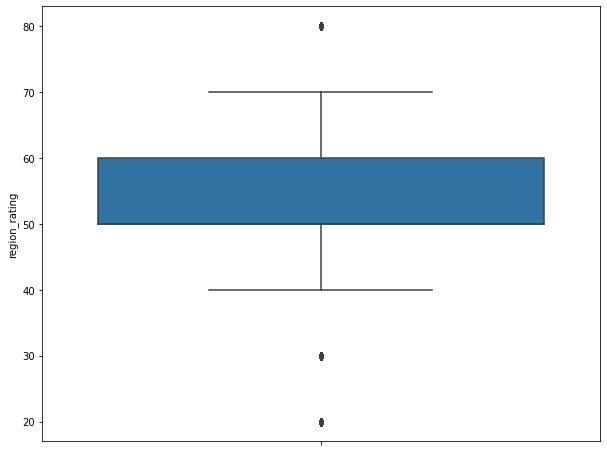

In [33]:
display(outliers(train, 'region_rating'))
#_ = sns.boxplot(x='default', y='region_rating', data=train)
plt.figure(figsize=(10, 8))
_ = sns.boxplot(y='region_rating', data=train)

In [34]:
#  Есть выбросы, но скорее всего крайние значения как раз сильно влияют на дефолт, оставляем как есть

In [35]:
# Посмотрим есть ли влияние этих признаков на целевую переменную
f, p = f_classif(train[['region_rating']], train['default'])
print(f'F-statistic = {f[0]}, p_value = {p[0]}')

F-statistic = 589.6783810095484, p_value = 9.538196611988627e-130


### Income

25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0, Границы выбросов: [-22000.0, 90000.0]


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
28,15681,2014-01-23,UGR,M,37,Y,Y,0,0,-1.740676,3,80,2,3,100000,1,3,N,0
54,24780,2014-01-31,GRD,F,36,Y,Y,0,0,-1.801896,8,60,1,1,200000,1,3,Y,0
67,18358,2014-01-25,GRD,F,30,Y,Y,0,0,-2.000578,3,60,2,1,130000,1,3,N,0
72,53637,2014-03-02,SCH,F,27,N,N,0,1,-1.774092,0,40,2,3,350000,1,3,N,0
76,57757,2014-03-06,GRD,M,40,Y,N,0,1,-2.143950,0,50,1,1,100000,3,3,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73731,89476,2014-04-06,GRD,F,53,Y,Y,0,0,-2.022001,2,60,2,3,200000,1,4,N,0
73739,48556,2014-02-25,GRD,F,35,N,N,0,0,-1.839626,6,50,2,3,120000,1,2,N,1
73740,23484,2014-01-30,GRD,F,38,Y,Y,0,1,-1.077477,1,80,2,3,200000,1,3,N,0
73749,10628,2014-01-17,UGR,F,29,N,N,0,0,-2.134235,4,80,2,3,120000,1,3,N,0


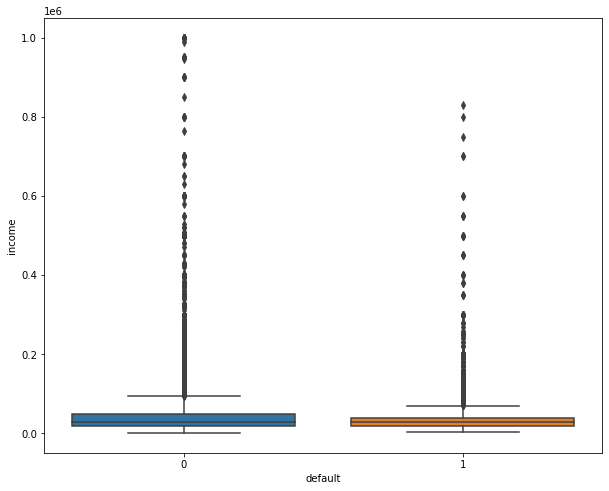

In [36]:
display(outliers(train, 'income'))
plt.figure(figsize=(10, 8))
_ = sns.boxplot(x='default', y='income', data=train)

In [37]:
# Выбросов много, но определить где начинается и заканчивается реальный доход очень тяжело. 
# Скорее всего доход 1000 (вопрос чего) - это действитель неправдоподобно мало, 
# а доход ровно 999999 выглядит странно, но возможно это тоже индикатор для принятия решений
# Если можно было-бы узнать как получены эти данные

In [38]:
# Посмотрим есть ли влияние этих признаков на целевую переменную
f, p = f_classif(train[['income']], train['default'])
print(f'F-statistic = {f[0]}, p_value = {p[0]}')

F-statistic = 116.79801365748176, p_value = 3.3312352190447544e-27


<AxesSubplot:>

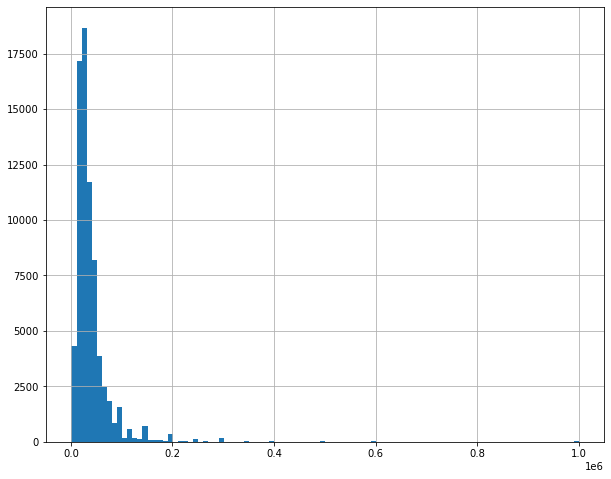

In [39]:
plt.figure(figsize=(10, 8))
train['income'].hist(bins=100)

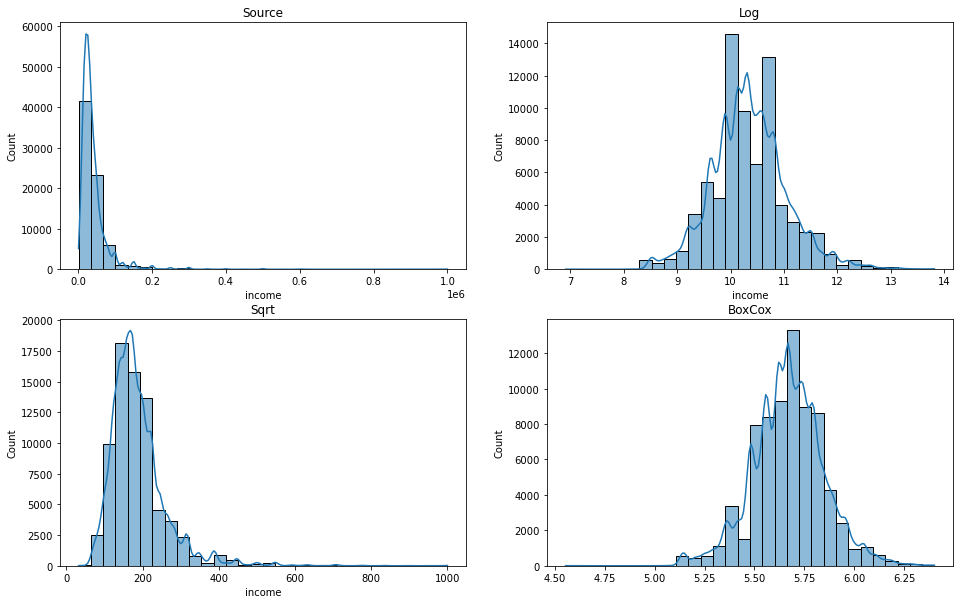

In [40]:
# У признака большой правый хвост - попробуем исправить 
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16, 10)
indices = train['income'] > 0
ax[0][0].set_title('Source')
_ = sns.histplot(train.loc[indices, 'income'], fill=True, kde=True, bins=30, ax=ax[0][0])
ax[0][1].set_title('Log')
_ = sns.histplot(np.log(train.loc[indices, 'income']), fill=True, kde=True, bins=30, ax=ax[0][1])
ax[1][0].set_title('Sqrt')
_ = sns.histplot(np.sqrt(train.loc[indices, 'income']), fill=True, kde=True, bins=30, ax=ax[1][0])
ax[1][1].set_title('BoxCox')
_ = sns.histplot(stats.boxcox(train.loc[indices, 'income'])[0], fill=True, kde=True, bins=30, ax=ax[1][1])

In [41]:
# После логарифма и бокса-кокса стало гораздо лучше

### SNA

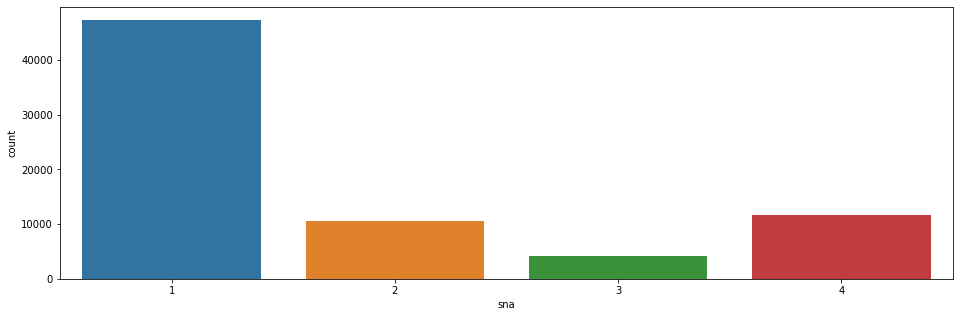

In [42]:
# Вообще непонятный параметр. Что означает "связь заемщика с клиентами банка"? 
# Сколько человек? Балльная оценка? Если баллы что лучше 1 или 4?
# Будем рассматривать как баллы
plt.figure(figsize=(16, 5))
_ = sns.countplot(x='sna', data=train)

<AxesSubplot:>

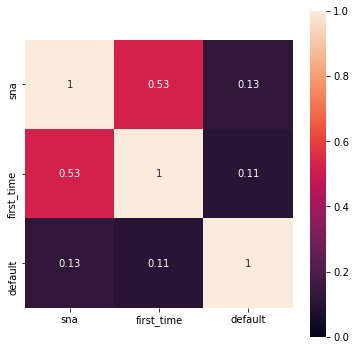

In [43]:
# Интересна обратная корреляция между sna и first_time
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(train[['sna', 'first_time', 'default']].corr().abs(), vmin=0, vmax=1, annot=True, square=True)

### First_time

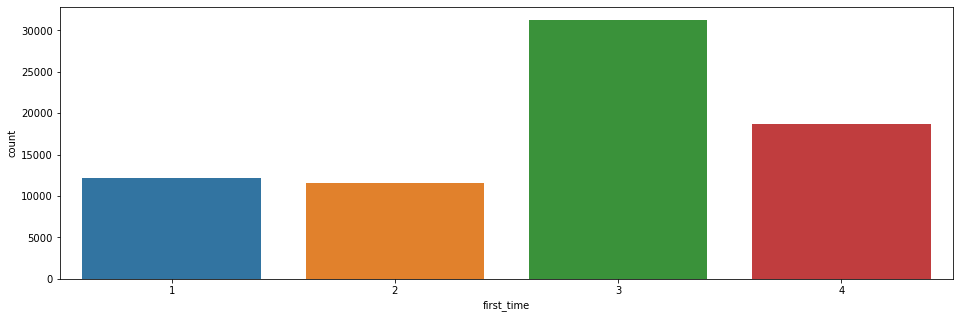

In [44]:
# Тоже непонятный признак "давность наличия информации о заемщике".
# Но здесь скорее всего категория 1 - небольшая давность, 4 - большая
# Тогда можно объяснить корреляцию (чем меньше давность, тем больше связь с клиентами)
plt.figure(figsize=(16, 5))
_ = sns.countplot(x='first_time', data=train)

### И на "сладкое" default

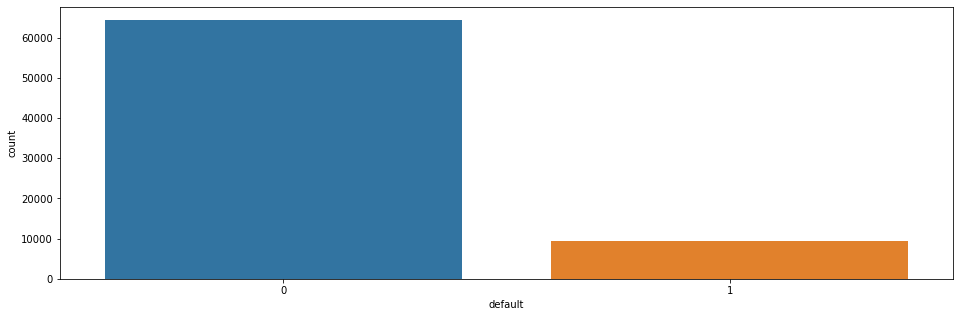

In [45]:
# Из профайлера видно, что есть большой перекос в данных. Не 10 к одному, но 87 к 13 тоже много.
# Надо будет учитывать при построении модели
plt.figure(figsize=(16, 5))
_ = sns.countplot(x='default', data=train)

In [46]:
len(train[train['default'] == 1]) / len(train[train['default'] == 0])

0.14546696260884412

## Предобработка

In [47]:
# Заполнить пропуски в education = 'UNK'
train['education'].fillna('UNK', inplace=True)
train['education'].value_counts()

SCH    38860
GRD    23365
UGR     9816
PGR     1257
UNK      307
ACD      194
Name: education, dtype: int64

In [48]:
train.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
46695,56913,2014-03-05,UGR,M,38,N,N,1,0,-1.552940,2,50,1,1,60000,1,3,N,0
62691,50763,2014-02-27,PGR,F,40,N,N,0,1,-1.920823,1,50,1,2,15000,1,4,Y,0
46771,85903,2014-04-02,PGR,F,28,N,N,1,0,-2.060091,3,50,1,3,45000,4,1,N,0
39857,96714,2014-04-13,GRD,F,25,N,N,0,0,-1.807345,0,60,2,3,20000,1,2,N,0
72575,39712,2014-02-16,GRD,M,53,N,N,0,1,-2.792920,1,40,1,2,21000,1,4,N,0


In [49]:
def boxcox(df):
    boxcox_df = df.copy()
    for f in df.columns:
        zero_indices = df[f] == 0
        bc, lam = stats.boxcox(df.loc[df[f] > 0, f])
        boxcox_df.loc[~zero_indices, f] = bc
        boxcox_df.loc[zero_indices, f] = -1 / lam
    return boxcox_df    


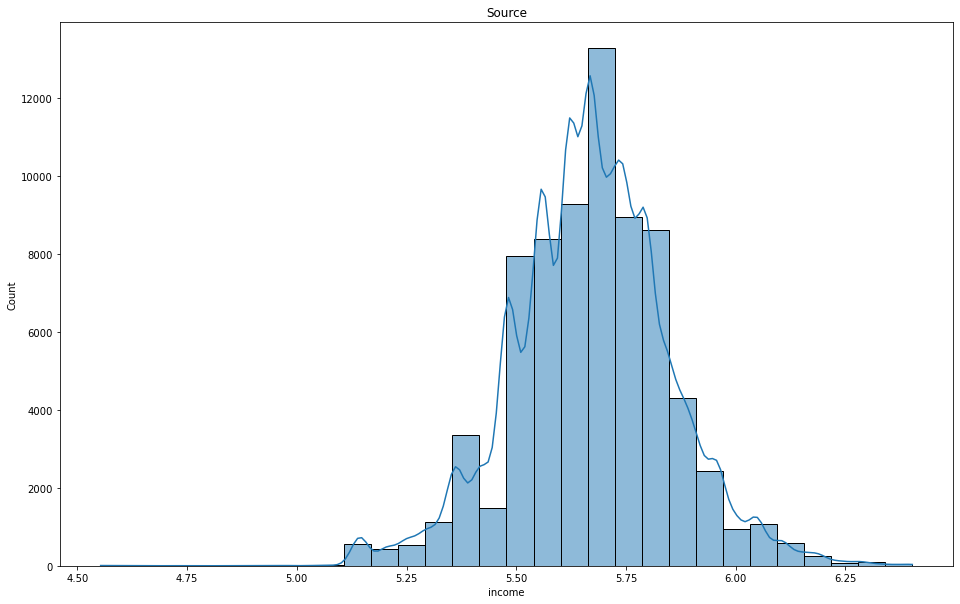

In [50]:
# У income большой правый хвость применим преобразование Бокса-Кокса к признаку
train['income'] = boxcox(train[['income']])
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)
ax.set_title('Source')
_ = sns.histplot(train['income'], fill=True, kde=True, bins=30, ax=ax)

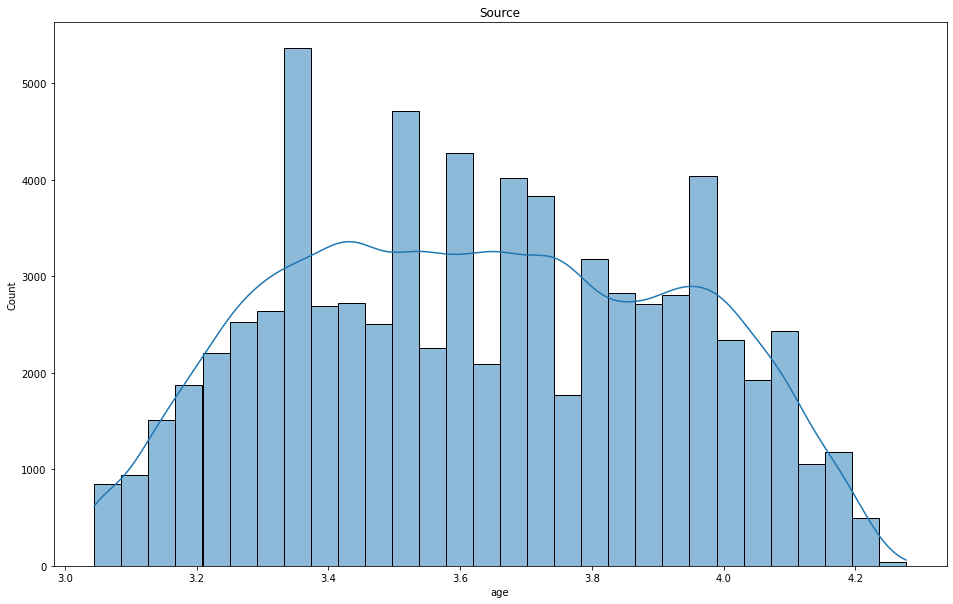

In [51]:
# У age большой правый хвость применим преобразование логарифмирование к признаку
train['age'] = np.log(train['age'])
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)
ax.set_title('Source')
_ = sns.histplot(train['age'], fill=True, kde=True, bins=30, ax=ax)

### Feature engineering

In [52]:
num_features = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
bin_features = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_features = ['education', 'work_address', 'home_address']
ord_features = ['sna', 'first_time', 'region_rating']
del_features = ['client_id', 'app_date']
target = 'default'
len(num_features + bin_features + cat_features + ord_features + del_features + [target])

19

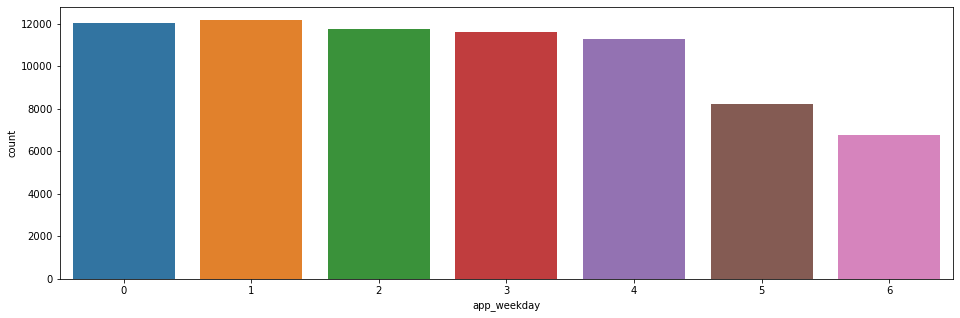

In [53]:
train['app_weekday'] = train['app_date'].dt.weekday
cat_features.append('app_weekday')
plt.figure(figsize=(16, 5))
_ = sns.countplot(x='app_weekday', data=train)

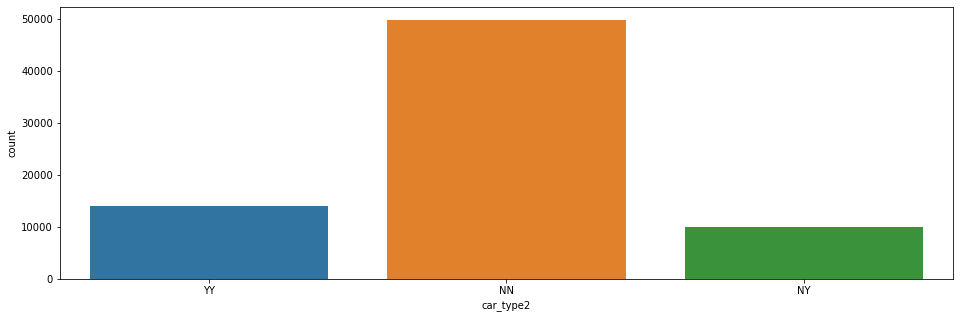

In [54]:
train['car_type2'] = train['car_type'] + train['car']
cat_features.append('car_type2')
plt.figure(figsize=(16, 5))
_ = sns.countplot(x='car_type2', data=train)

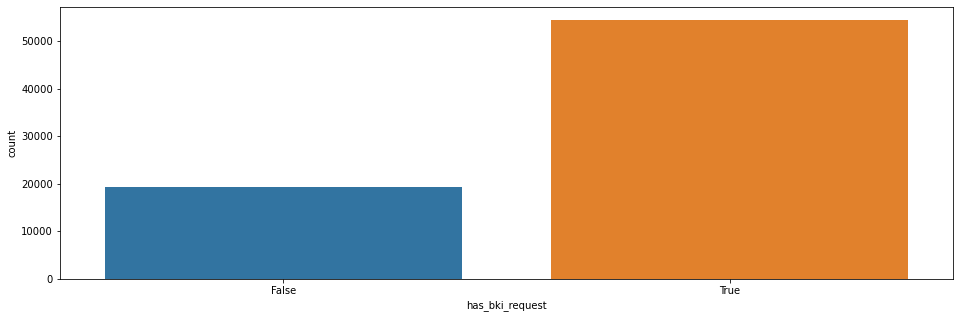

In [55]:
train['has_bki_request'] = train['bki_request_cnt'] > 0
bin_features.append('has_bki_request')
plt.figure(figsize=(16, 5))
_ = sns.countplot(x='has_bki_request', data=train)

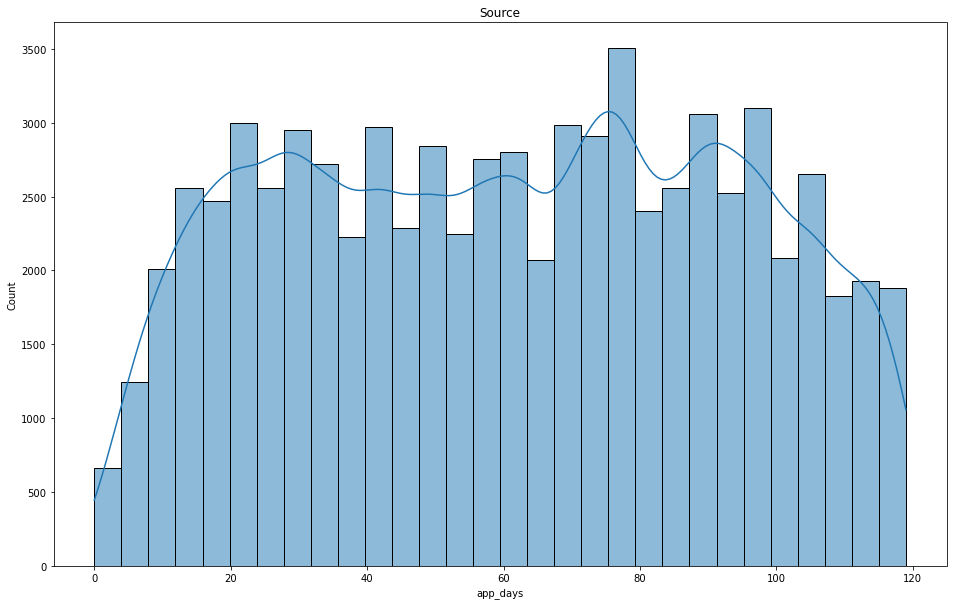

In [56]:
train['app_days'] = (train['app_date'] - datetime(2014, 1, 1)).dt.days
num_features.append('app_days')
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)
ax.set_title('Source')
_ = sns.histplot(train['app_days'], fill=True, kde=True, bins=30, ax=ax)

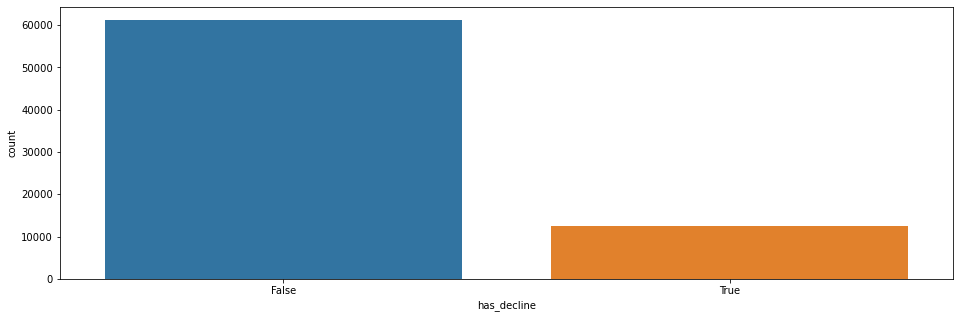

In [57]:
train['has_decline'] = train['decline_app_cnt'] > 0
bin_features.append('has_decline')
plt.figure(figsize=(16, 5))
_ = sns.countplot(x='has_decline', data=train)

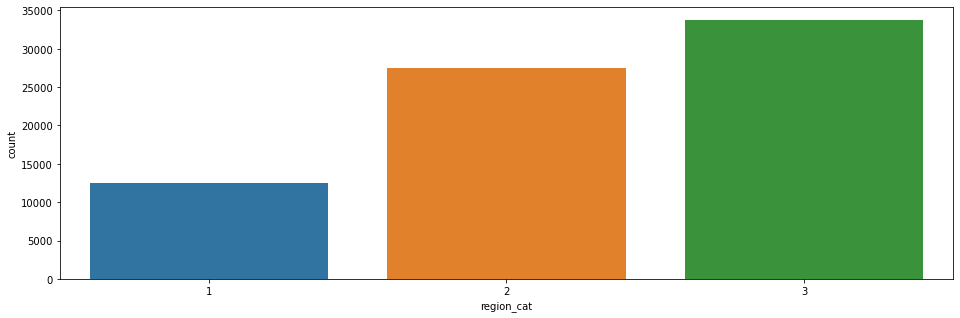

In [58]:
train['region_cat'] = train['region_rating'].apply(lambda x: 2 if x == 50 else 1 if x < 50 else 3)
cat_features.append('region_cat')
plt.figure(figsize=(16, 5))
_ = sns.countplot(x='region_cat', data=train)


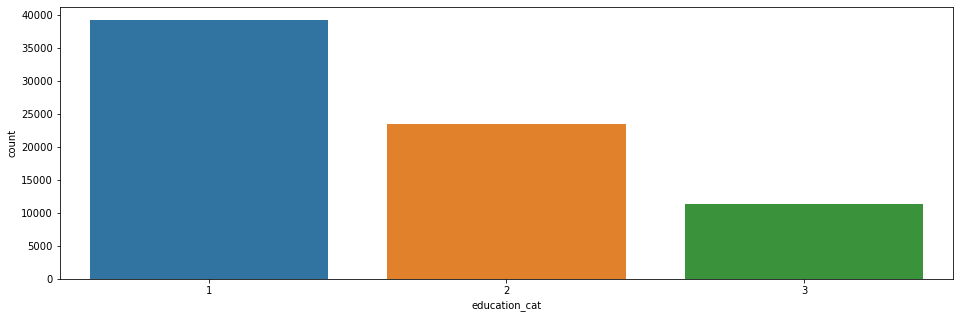

In [59]:
edu_map = {'UNK': 1, 'SCH': 1, 'GRD': 2, 'UGR': 3, 'PGR': 3, 'ACD': 3}
train['education_cat'] = train['education'].map(edu_map)
cat_features.append('education_cat')
plt.figure(figsize=(16, 5))
_ = sns.countplot(x='education_cat', data=train)


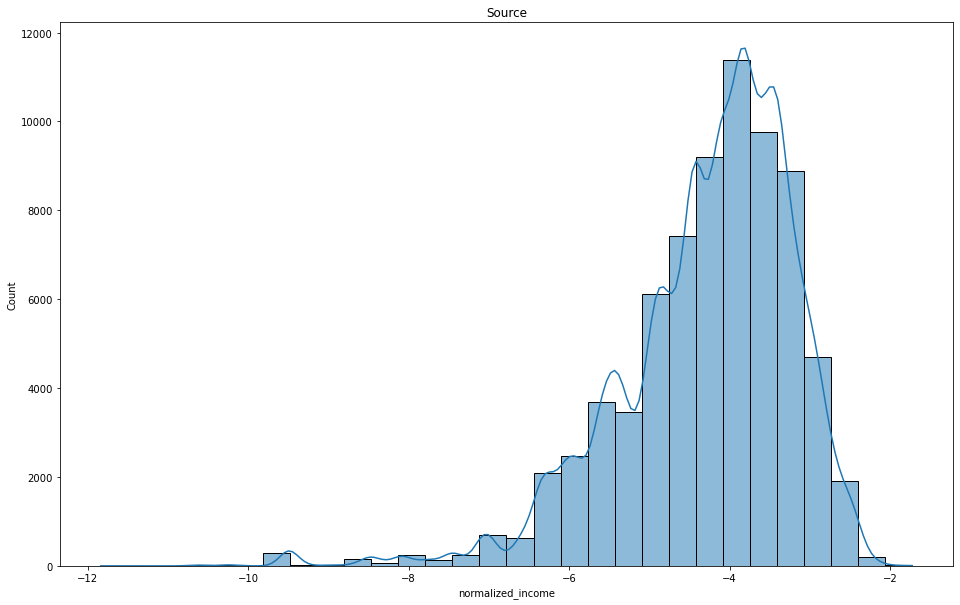

In [60]:
mean_income = train.groupby('age')['income'].mean().to_dict()
mean_income_age = train['age'].map(mean_income)
max_income = train.groupby('age')['income'].max().to_dict()
max_income_age = train['age'].map(max_income)        
train['normalized_income'] = np.log(abs((train.income - mean_income_age) / max_income_age))
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)
ax.set_title('Source')
_ = sns.histplot(train['normalized_income'], fill=True, kde=True, bins=30, ax=ax)

### Feature selection

In [61]:
train.set_index('client_id', inplace=True)

In [62]:
train.sample(2)

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,foreign_passport,default,app_weekday,car_type2,has_bki_request,app_days,has_decline,region_cat,education_cat,normalized_income
client_id,,,,,,,,,,,,,,,,,,,,,
13082,2014-01-20,SCH,M,3.637586,N,N,0,0,-2.420865,1,...,N,0,0,NN,True,19,False,1,1,-4.494514
80874,2014-03-28,GRD,F,3.526361,N,N,0,0,-2.350645,2,...,N,0,4,NN,True,86,False,1,2,-4.479010


In [63]:
def showImportance(features_imp, features, n=20):
    imp_df = pd.DataFrame(features_imp.T, columns=['importance'], index=features)
    imp_df = np.abs(imp_df)
    imp_df = imp_df.sort_values(by='importance', ascending=False)
    f, ax = plt.subplots(1, 1, figsize=(16, 10), sharex=True)
    df4display = imp_df.head(n)
    sns.barplot(x=df4display['importance'], y=df4display.index, palette="vlag", ax=ax)
    _ = ax.set_ylabel("Признак")
    _ = ax.set_title("Значимость признаков")


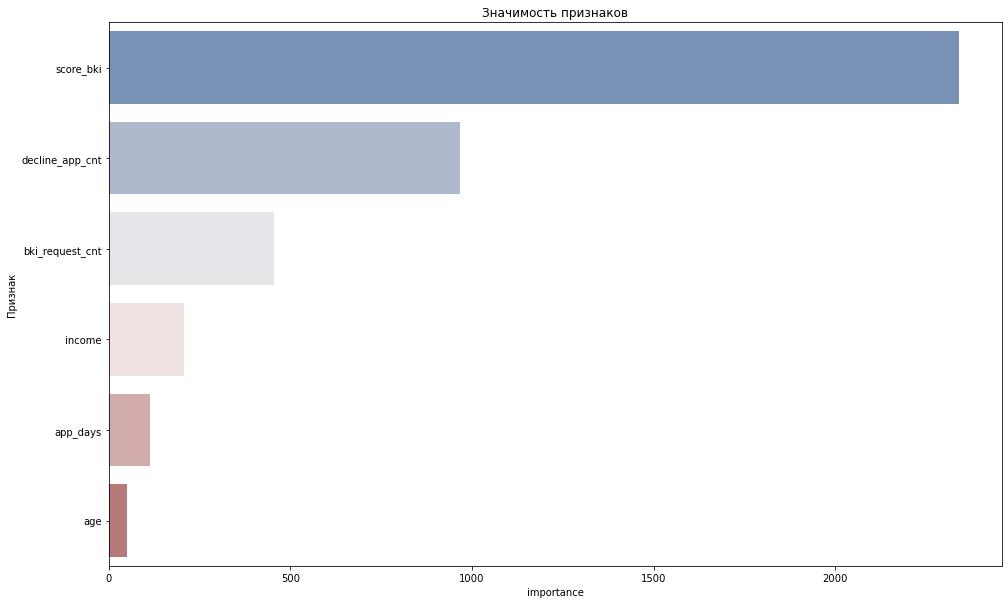

In [64]:
f_cls = f_classif(train[num_features], train['default'])
showImportance(f_cls[0], num_features)

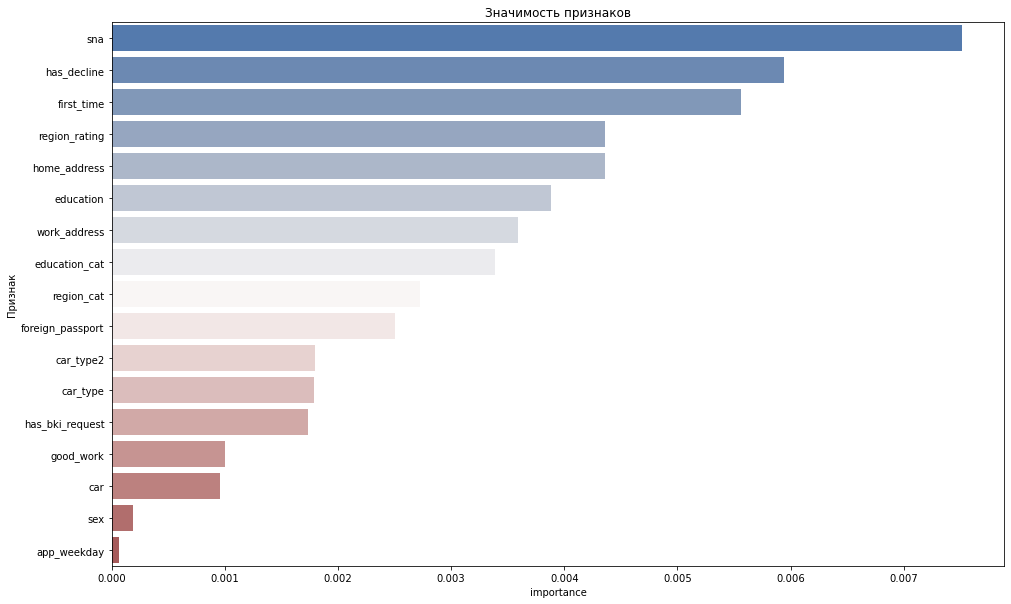

In [65]:
temp_df = train[bin_features + cat_features + ord_features + ['default']].copy()
label_encoder = LabelEncoder()
for feature in bin_features + cat_features:
    temp_df[feature] = label_encoder.fit_transform(train[feature])
mis = mutual_info_classif(temp_df[bin_features + cat_features + ord_features], 
                          temp_df['default'], discrete_features=True)
showImportance(mis, bin_features + cat_features + ord_features)

### Check correlation

In [66]:
# Корреляция между числовыми признаками набора данных
def showNumCorr(df, features, title='Корреляция между данными'):
    # Корреляция между данными о ролике
    plt.figure(figsize=(16, 10))
    mask = np.triu(np.ones_like(df[features].corr(), dtype=bool))
    heatmap = sns.heatmap(df[features].corr(),
                          mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap = heatmap.set_title(title, fontdict={'fontsize': 18}, pad=16)    
    return heatmap

Text(0.5, 1.0, 'Корреляция между данными')

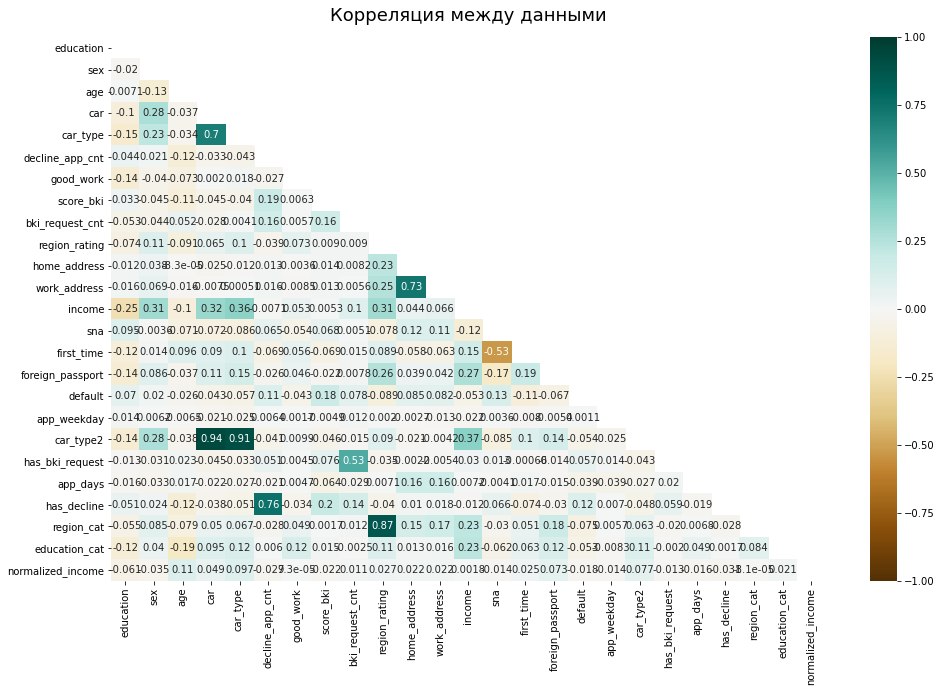

In [67]:
temp_df = train.copy()
temp_df.drop('app_date', axis=1, inplace=True)
label_encoder = LabelEncoder()
for feature in bin_features + cat_features:
    temp_df[feature] = label_encoder.fit_transform(train[feature])
showNumCorr(temp_df, temp_df.columns)

In [68]:
# Получили значительную корреляцию car_type2 c car и car_type
train.drop(['car', 'car_type'], axis=1, inplace=True, errors='ignore')
if 'car' in bin_features:
    bin_features.remove('car') 
if 'car_type' in bin_features:
    bin_features.remove('car_type') 
# и region_rating c region_cat при этом все таки region_rating все таки больше влияет на default
train.drop(['region_cat'], axis=1, inplace=True, errors='ignore')
if 'region_cat' in cat_features:
    cat_features.remove('region_cat') 

In [69]:
### Features preparing

In [70]:
# Binary features encode
label_encoder = LabelEncoder()
for feature in bin_features:
    train[feature] = label_encoder.fit_transform(train[feature])
train.sample(2)

,app_date,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,...,first_time,foreign_passport,default,app_weekday,car_type2,has_bki_request,app_days,has_decline,education_cat,normalized_income
client_id,,,,,,,,,,,,,,,,,,,,,
47006,2014-02-24,SCH,0,3.663562,1,0,-1.742570,9,50,2,...,3,0,1,0,NN,1,54,1,1,-4.416330
49758,2014-02-26,ACD,0,3.806662,0,0,-1.252763,0,50,2,...,3,0,1,2,NN,0,56,0,3,-3.545212


In [71]:
# Categorical features encode
onehot_encoder = OneHotEncoder(sparse = False, handle_unknown='ignore')
onehot_encoder = onehot_encoder.fit(train[cat_features])
df = pd.DataFrame(onehot_encoder.transform(train[cat_features]), 
                  columns=onehot_encoder.get_feature_names(input_features=cat_features),
                  index=train.index, dtype=int)
train = train.drop(cat_features, axis=1)
train = pd.concat([train, df], axis=1)
train.sample(2)

,app_date,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,sna,...,app_weekday_3,app_weekday_4,app_weekday_5,app_weekday_6,car_type2_NN,car_type2_NY,car_type2_YY,education_cat_1,education_cat_2,education_cat_3
client_id,,,,,,,,,,,,,,,,,,,,,
100971,2014-04-18,0,3.367296,0,0,-2.133999,3,60,5.560409,1,...,0,1,0,0,1,0,0,0,1,0
95746,2014-04-12,0,3.583519,0,0,-2.307949,1,50,5.668952,1,...,0,0,1,0,1,0,0,1,0,0


In [72]:
scaler = StandardScaler()
scaler.fit(train[num_features])
scaled_df = pd.DataFrame(scaler.transform(train[num_features]), 
                         columns=num_features, index=train.index)
train = train.drop(num_features, axis=1)
train = pd.concat([train, scaled_df], axis=1)
train.sample(2)

,app_date,sex,good_work,region_rating,sna,first_time,foreign_passport,default,has_bki_request,has_decline,...,car_type2_YY,education_cat_1,education_cat_2,education_cat_3,age,score_bki,decline_app_cnt,bki_request_cnt,income,app_days
client_id,,,,,,,,,,,,,,,,,,,,,
101988,2014-04-19,0,0,50,1,4,0,0,1,0,...,0,0,1,0,1.592548,0.725805,-0.342858,1.331965,0.565544,1.462084
4287,2014-01-10,0,0,50,1,2,0,0,1,0,...,0,1,0,0,1.476771,0.253145,-0.342858,-0.444189,0.292464,-1.619948


In [73]:
train.drop('app_date', axis=1, inplace=True, errors='ignore')
train.sample(2)

,sex,good_work,region_rating,sna,first_time,foreign_passport,default,has_bki_request,has_decline,normalized_income,...,car_type2_YY,education_cat_1,education_cat_2,education_cat_3,age,score_bki,decline_app_cnt,bki_request_cnt,income,app_days
client_id,,,,,,,,,,,,,,,,,,,,,
82426,1,0,50,4,1,0,0,0,0,-3.981887,...,1,0,1,0,-1.134435,0.080291,-0.342858,-0.888227,0.70967,0.839451
89130,1,0,40,1,4,1,0,0,0,-4.160004,...,0,1,0,0,0.374467,0.909498,-0.342858,-0.888227,0.70967,1.026241


### Make base model

In [74]:
def showImportance(model, features, n=20):
    lr_coef = pd.DataFrame(model.coef_.T, columns=['coefficient'], index=features)
    f, ax = plt.subplots(1, 1, figsize=(16, 10), sharex=True)
    top_lr_coef = lr_coef.sort_values(by='coefficient', ascending=False).head(n)
    low_lr_coef = lr_coef.sort_values(by='coefficient', ascending=False).tail(n)
    df4display = pd.concat([top_lr_coef, low_lr_coef])
    sns.barplot(x=df4display['coefficient'], y=df4display.index, palette="vlag", ax=ax)
    _ = ax.set_ylabel("Признак")
    _ = ax.set_title("Значимость признаков")
    
    
def showMetrics(y_test, y_prob, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['success','default'])
    fpr, tpr, threshold = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(16, 6)

    ax[0].plot([0, 1], label='Baseline', linestyle='--')
    ax[0].plot(fpr, tpr, label = 'Regression')
    ax[0].set_title('ROC AUC = %0.10f' % roc_auc)
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].legend(loc='lower right')

    cmd.plot(ax=ax[1])
    cmd.ax_.set(xlabel='Predicted', ylabel='True')
    plt.show()

def split(df):
    X_train, X_test, y_train, y_test = train_test_split(df.drop('default', axis=1), 
                                                    df['default'], 
                                                    test_size=0.20, 
                                                    stratify=df['default'], 
                                                    random_state=42)
    return X_train, X_test, y_train, y_test


In [75]:
class ScorerHistory:
    scores_columns = ['estimator', 'roc_auc',
                      'accuracy', 'precision', 'recall', 'f1']
    scores_df = pd.DataFrame([], columns=scores_columns)

    def add2scores(name, y_test, y_pred, y_prob):
        df = pd.DataFrame([[name,
                            roc_auc_score(y_test, y_prob),
                            accuracy_score(y_test, y_pred),
                            precision_score(y_test, y_pred),
                            recall_score(y_test, y_pred),
                            f1_score(y_test, y_pred)]], columns=ScorerHistory.scores_columns)
        ScorerHistory.scores_df = pd.concat([ScorerHistory.scores_df, df], axis=0)
        return ScorerHistory.scores_df
    

class ScorerBase():
    '''
    Базовый класс для предобработки данных
    Делает кодирование, шкалирование, обучение модели и предсказания
    '''
    def __init__(self, X_train, y_train):
        self._data = X_train
        self._target = y_train
        self._features = {
            'num': ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income'],
            'cat': ['education', 'work_address', 'home_address'],
            'ord': ['region_rating', 'first_time', 'sna'],
            'bin': ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
        }
        
        
    def prepare(self, df, features):
        new_features = copy.deepcopy(features)
        columns = []
        for v in new_features.values():
            for f in v:
                columns.append(f)
        new_df = df.copy(columns)
        # Clean data
        new_df['education'].fillna('SCH', inplace=True)
        # Дата представлена в формате %d%b%Y - сразу переведем в тип datetime
        new_df['app_date'] = pd.to_datetime(data['app_date'])        
        return new_df, new_features
    
    def fit(self, df, features):
        # Fit encoders and scalers
        self._label_encoder = LabelEncoder()
        self._onehot_encoder = OneHotEncoder(sparse = False, handle_unknown='ignore')
        onehot_encoder = self._onehot_encoder.fit(df[features['cat']])
        self._num_scaler = StandardScaler()
        self._num_scaler.fit(df[features['num']])
        self._ord_scaler = StandardScaler()
        self._ord_scaler.fit(df[features['ord']])
        return self
    
    def transform(self, df, features):
        assert(self._label_encoder is not None)
        assert(self._onehot_encoder is not None)
        assert(self._num_scaler is not None)
        assert(self._ord_scaler is not None)
        new_df = pd.DataFrame([], index=df.index)
        # Binary features encode
        for feature in features['bin']:
            new_df[feature] = self._label_encoder.fit_transform(df[feature])
        # Categorical features encode
        columns = self._onehot_encoder.get_feature_names(input_features=features['cat'])
        encoded_df =  pd.DataFrame(self._onehot_encoder.transform(df[features['cat']]), 
                                   columns=columns, index=df.index, dtype=int)
        new_df = pd.concat([new_df, encoded_df], axis=1)
        # Numeric features scale
        scaled_df = pd.DataFrame(self._num_scaler.transform(df[features['num']]), 
                                 columns=features['num'], index=df.index)
        new_df = pd.concat([new_df, scaled_df], axis=1)
        # Ordered features 
#        scaled_df = pd.DataFrame(self._ord_scaler.transform(df[features['ord']]), 
#                                 columns=features['ord'], index=df.index)
        scaled_df = df[features['ord']]
        new_df = pd.concat([new_df, scaled_df], axis=1)
        return new_df
    
    def prepare_fit_transform(self):
        (df, features)  = self.prepare(self._data, self._features)
        self.fit(df, features)
        return self.transform(df, features), self._target
    
    def get_target(self):
        return self._target
    
    def train(self, model):
        self._model = model
        assert(self._model is not None)
        (df, features) = self.prepare(self._data, self._features)
        df = self.fit(df, features).transform(df, features)
        self._model.fit(df, self._target)
        return model
    
    def predict(self, test):
        assert(self._model is not None)
        (df, features) = self.prepare(test, self._features)
        df = self.transform(df, features)
        return self._model.predict(df)

    def predict_proba(self, test):
        assert(self._model is not None)
        (df, features) = self.prepare(test, self._features)
        df = self.transform(df, features)
        return self._model.predict_proba(df)[:,1]
    

,sex,car,car_type,foreign_passport,good_work,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,...,home_address_2,home_address_3,age,score_bki,decline_app_cnt,bki_request_cnt,income,region_rating,first_time,sna
58785,0,0,0,0,0,0,0,0,1,0,...,0,0,1.971476,-0.499605,-0.340320,0.001496,0.191290,50,2,1
15228,0,0,0,0,0,0,0,0,1,0,...,0,0,-1.414091,1.057010,-0.340320,0.001496,-0.562980,60,1,4
55789,0,0,0,0,0,0,0,0,1,0,...,1,0,2.318714,0.645538,-0.340320,0.445309,-0.627632,60,4,3
1693,0,0,0,0,0,0,0,0,1,0,...,0,0,-1.066854,-1.267088,0.892477,-0.442317,-0.131968,50,2,2
18742,0,0,0,0,0,0,0,0,1,0,...,0,0,-0.025140,-0.129151,-0.340320,0.001496,-0.562980,60,2,1


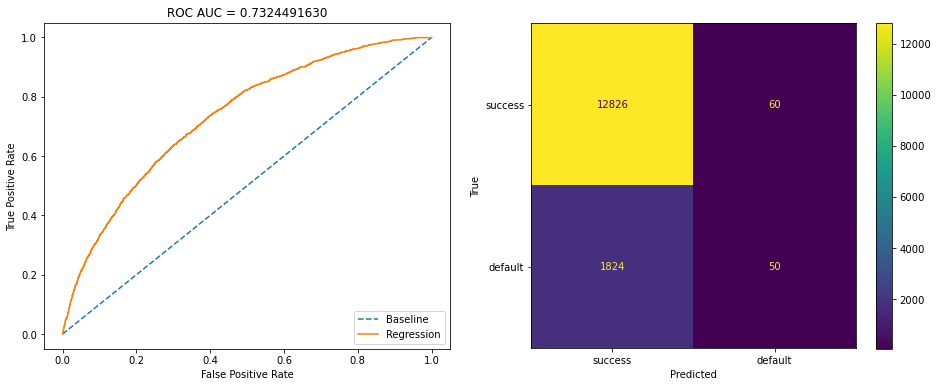

,estimator,roc_auc,accuracy,precision,recall,f1
0,base,0.732449,0.872358,0.454545,0.026681,0.050403


In [76]:
# Base model
data = pd.read_csv(DATA_PATH + '/train.csv')
X_train, X_test, y_train, y_test = split(data)
scorer = ScorerBase(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))
model = LogisticRegression(max_iter=1000, random_state=42)
scorer.train(model)
y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('base', y_test, y_pred, y_prob)

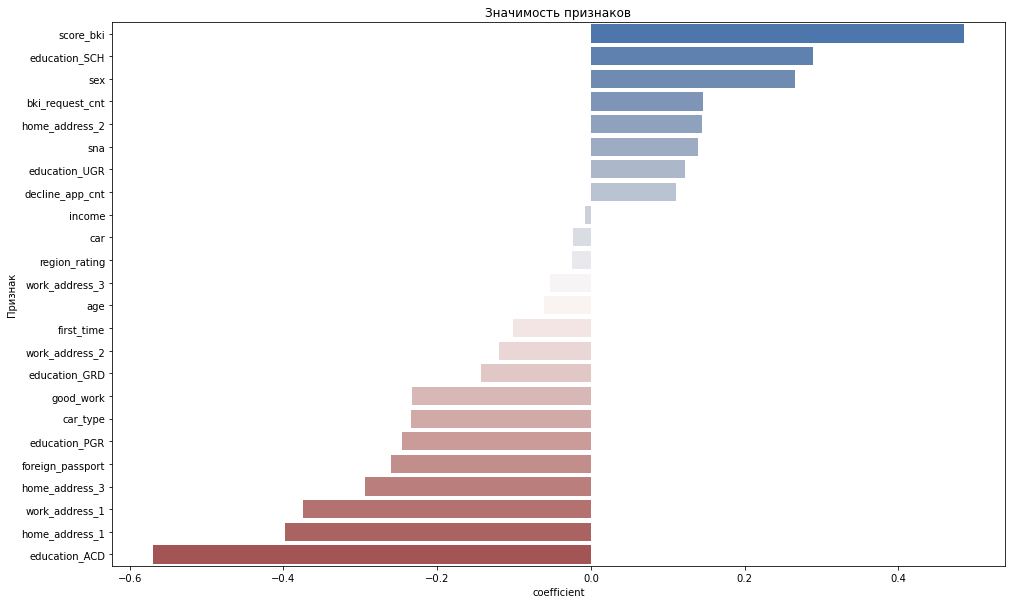

In [77]:
showImportance(model, scorer.prepare_fit_transform()[0].columns, n=20)

In [78]:
class ScorerGen(ScorerBase):
    '''
    Класс для предобработки данных с переопределеннм методом prepare,
    где генирируются и отбираются признаки
    '''
    
    def boxcox(self, df):
        boxcox_df = df.copy()
        for f in df.columns:
            zero_indices = df[f] == 0
            bc, lam = stats.boxcox(df.loc[df[f] > 0, f])
            boxcox_df.loc[~zero_indices, f] = bc
            boxcox_df.loc[zero_indices, f] = -1 / lam
        return boxcox_df    
    
    def prepare(self, df, features):
        (df, features) = super().prepare(df, features)
        
        # Add features
        mean_income = df.groupby('age')['income'].mean().to_dict()
        df['mean_income_age'] = df['income'] - df['age'].map(mean_income)                       
        features['num'].append('mean_income_age')

        mean_decline = df.groupby('age')['decline_app_cnt'].mean().to_dict()
        df['mean_decline_age'] = df['decline_app_cnt'] - df['age'].map(mean_decline)                       
        features['num'].append('mean_decline_age')

        mean_request = df.groupby('age')['bki_request_cnt'].mean().to_dict()
        df['mean_request_age'] = df['bki_request_cnt'] - df['age'].map(mean_request)                       
        features['num'].append('mean_request_age')

        df['income'] = self.boxcox(df[['income']])
        df['app_days'] = (df['app_date'] - datetime(2014, 1, 1)).dt.days
        features['num'].append('app_days')
        df['decline_app_cnt'] = df['decline_app_cnt'].apply(lambda x: x if x < 4 else 4)
        df['bki_request_cnt'] = df['bki_request_cnt'].apply(lambda x: x if x < 4 else 4)
        
        # remove features
 
        return df, features
    
            

,sex,car,car_type,foreign_passport,good_work,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,...,decline_app_cnt,bki_request_cnt,income,mean_income_age,mean_decline_age,mean_request_age,app_days,region_rating,first_time,sna
4076,1,0,0,0,0,0,0,0,0,1,...,-0.382794,1.601721,-0.769918,-0.386760,-0.481499,1.419389,0.843394,60,1,4
9308,1,0,0,0,0,0,0,0,0,1,...,-0.382794,-0.493122,-1.415446,-0.587314,-0.432147,-0.441140,-1.430388,40,4,1
31864,1,0,0,0,0,0,0,0,0,1,...,1.080447,-0.493122,0.954352,0.601415,0.591210,-0.290032,-0.776286,40,3,2
36804,0,0,0,0,0,0,0,0,1,0,...,-0.382794,-1.191403,0.216378,-0.156101,-0.403039,-0.889291,0.967985,80,3,1
53208,1,0,0,0,0,0,0,0,1,0,...,-0.382794,0.205159,0.954352,0.280021,-0.272354,-0.098650,-0.745138,50,3,2


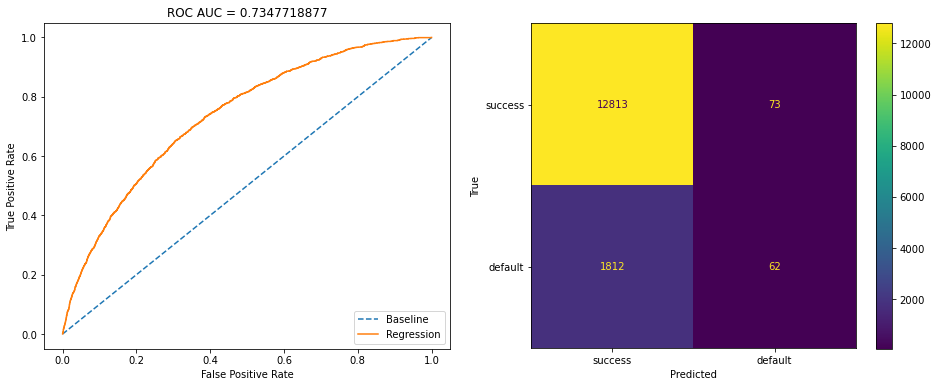

,estimator,roc_auc,accuracy,precision,recall,f1
0,base,0.732449,0.872358,0.454545,0.026681,0.050403
0,lr+gen,0.734772,0.872290,0.459259,0.033084,0.061722


In [79]:
# Model with generated features
data = pd.read_csv(DATA_PATH + '/train.csv')
X_train, X_test, y_train, y_test = split(data)
scorer = ScorerGen(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))
model = LogisticRegression(max_iter=1000, random_state=42)
scorer.train(model)
y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('lr+gen', y_test, y_pred, y_prob)

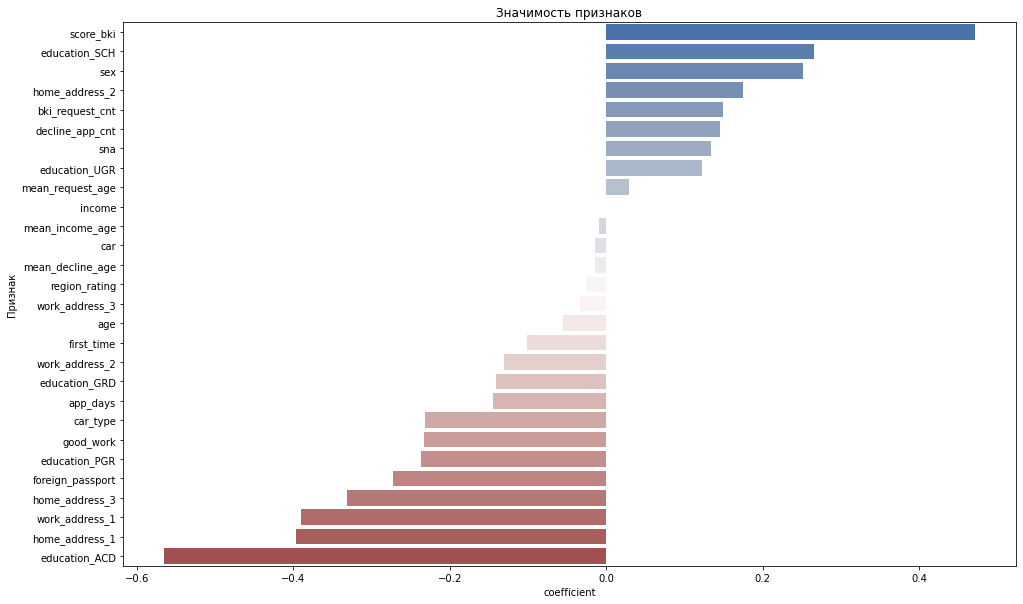

In [80]:
showImportance(model, scorer.prepare_fit_transform()[0].columns, n=20)

,sex,car,car_type,foreign_passport,good_work,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,...,decline_app_cnt,bki_request_cnt,income,mean_income_age,mean_decline_age,mean_request_age,app_days,region_rating,first_time,sna
1696,0,1,0,0,0,0,1,0,0,0,...,1.080447,-1.191403,-0.004571,-0.341376,0.852472,-0.905457,1.715529,50,4,1
3950,0,0,0,0,0,0,0,0,1,0,...,-0.382794,-0.493122,-0.607786,-0.535259,-0.224501,-0.505039,-1.586126,60,3,2
47471,1,1,1,1,0,0,1,0,0,0,...,1.080447,-0.493122,0.404152,0.166702,0.591210,-0.290032,-1.274649,70,3,2
57210,1,0,0,0,1,0,0,0,1,0,...,1.080447,-1.191403,-1.055892,-0.416919,0.688425,-0.759906,-0.932025,20,3,1
19502,0,1,1,0,0,0,0,0,1,0,...,-0.382794,1.601721,1.192268,0.578652,-0.302354,1.293078,-0.745138,50,3,2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.9s finished


Best C = [0.1]


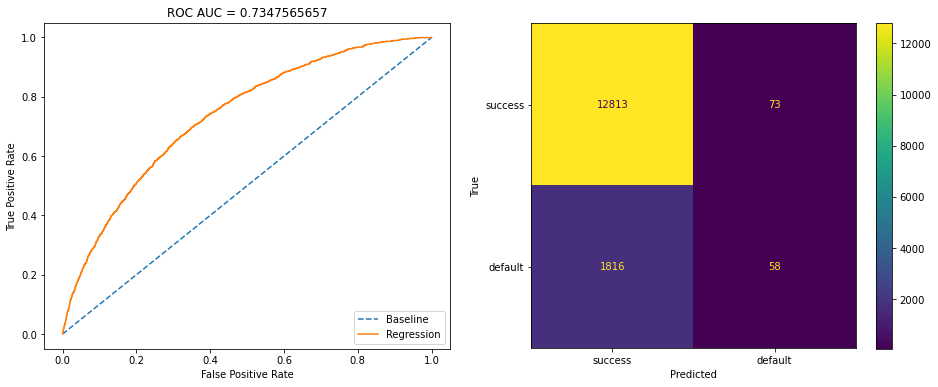

,estimator,roc_auc,accuracy,precision,recall,f1
0,base,0.732449,0.872358,0.454545,0.026681,0.050403
0,lr+gen,0.734772,0.872290,0.459259,0.033084,0.061722
0,lr+cv+f1,0.734757,0.872019,0.442748,0.030950,0.057855


In [81]:
from sklearn.model_selection import StratifiedKFold
# Model with generated features and LogisticRegressionCV
data = pd.read_csv(DATA_PATH + '/train.csv')
X_train, X_test, y_train, y_test = split(data)

scorer = ScorerGen(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))
Cs = np.logspace(-5, 5, 11)
cv = StratifiedKFold(5, shuffle=True, random_state=42)
model = LogisticRegressionCV(Cs=Cs, max_iter=1000, cv=cv, random_state=42,
                             n_jobs=-1, verbose=2, scoring='f1')
model = scorer.train(model)
print('Best C =', model.C_)
y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('lr+cv+f1', y_test, y_pred, y_prob)

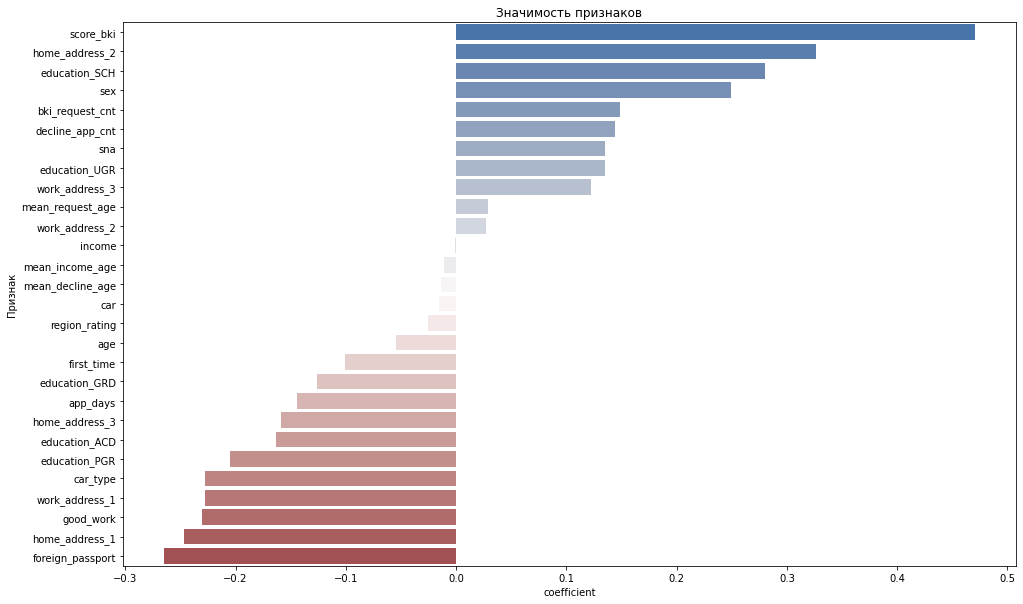

In [82]:
showImportance(model, scorer.prepare_fit_transform()[0].columns, n=20)

,sex,car,car_type,foreign_passport,good_work,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,...,decline_app_cnt,bki_request_cnt,income,mean_income_age,mean_decline_age,mean_request_age,app_days,region_rating,first_time,sna
37158,1,1,1,0,1,0,1,0,0,0,...,-0.382794,1.601721,0.088484,-0.152602,-0.432147,0.900027,0.407326,60,3,1
71306,1,0,0,0,0,0,1,0,0,0,...,-0.382794,1.601721,-0.004571,-0.345297,-0.301214,0.874537,1.154871,40,3,1
30996,0,0,0,0,0,0,1,0,0,0,...,-0.382794,0.903440,0.216378,-0.017254,-0.481499,0.525278,0.469622,80,2,4
46733,0,1,0,0,0,0,0,0,0,1,...,-0.382794,1.601721,0.567041,0.235151,-0.555687,1.028317,0.531917,80,3,1
19444,0,0,0,1,0,0,0,0,1,0,...,-0.382794,1.601721,-1.055892,-0.678554,-0.327279,0.849297,1.341757,60,2,2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.4s finished


Best C = [0.01]


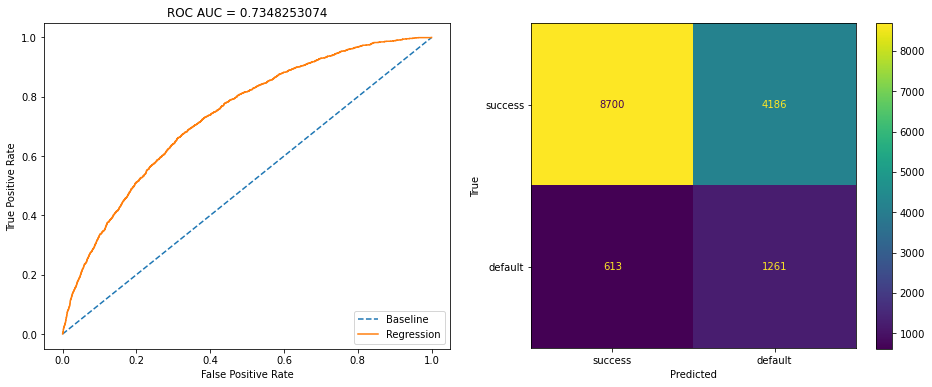

,estimator,roc_auc,accuracy,precision,recall,f1
0,base,0.732449,0.872358,0.454545,0.026681,0.050403
0,lr+gen,0.734772,0.872290,0.459259,0.033084,0.061722
0,lr+cv+f1,0.734757,0.872019,0.442748,0.030950,0.057855
0,lr+gen+cv+roc_auc+balance,0.734825,0.674864,0.231504,0.672892,0.344488


In [83]:
# Model with generated features and LogisticRegressionCV с балансировкой
data = pd.read_csv(DATA_PATH + '/train.csv')
X_train, X_test, y_train, y_test = split(data)

scorer = ScorerGen(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))
cv = StratifiedKFold(5, shuffle=True, random_state=42)
model = LogisticRegressionCV(Cs=9, max_iter=1000, cv=cv, random_state=42,
                             penalty='l2', solver='newton-cg',
                             verbose=2, n_jobs=-1, scoring='roc_auc', class_weight='balanced')
scorer.train(model)
print('Best C =', model.C_)
y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('lr+gen+cv+roc_auc+balance', y_test, y_pred, y_prob)

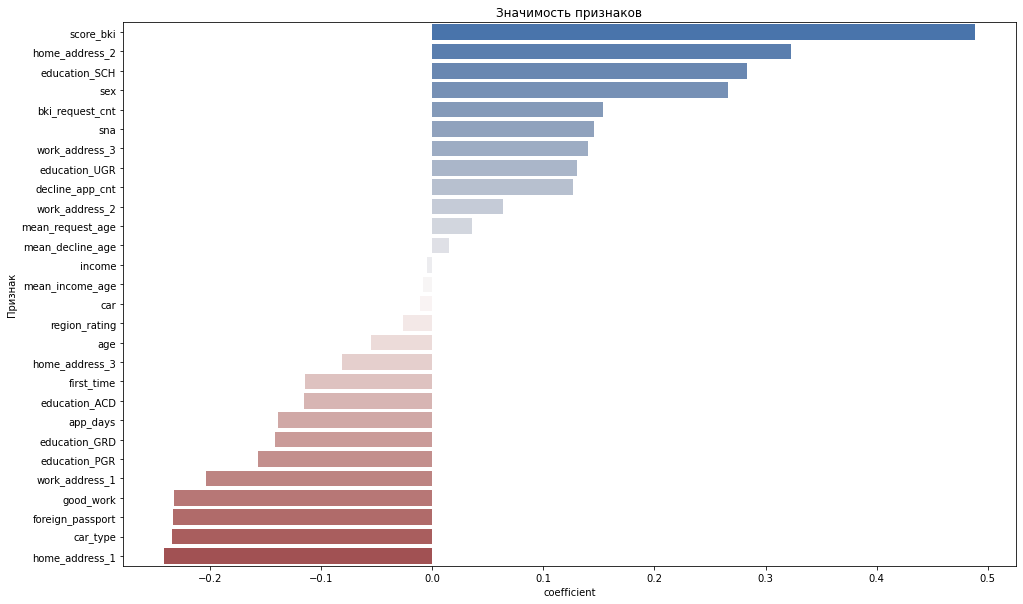

In [84]:
showImportance(model, scorer.prepare_fit_transform()[0].columns, n=20)

,sex,car,car_type,foreign_passport,good_work,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,...,decline_app_cnt,bki_request_cnt,income,mean_income_age,mean_decline_age,mean_request_age,app_days,region_rating,first_time,sna
47746,1,0,0,0,1,0,0,0,1,0,...,-0.382794,0.205159,-0.607786,-0.439075,-0.241061,-0.102679,1.061428,60,1,4
8944,1,1,1,1,0,0,1,0,0,0,...,1.080447,1.601721,3.289471,8.907249,1.003051,13.308994,0.126997,80,4,1
18106,1,0,0,0,0,0,0,0,1,0,...,-0.382794,0.205159,0.404152,-0.047423,-0.403039,0.004821,-1.399240,80,3,4
44437,0,1,1,0,0,0,1,0,0,0,...,-0.382794,-0.493122,0.710609,0.115475,-0.323201,-0.438941,-1.648421,80,3,4
56011,0,0,0,0,0,0,0,0,1,0,...,2.543688,0.903440,-0.158209,-0.393193,2.154873,0.390372,0.812246,60,3,3


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}


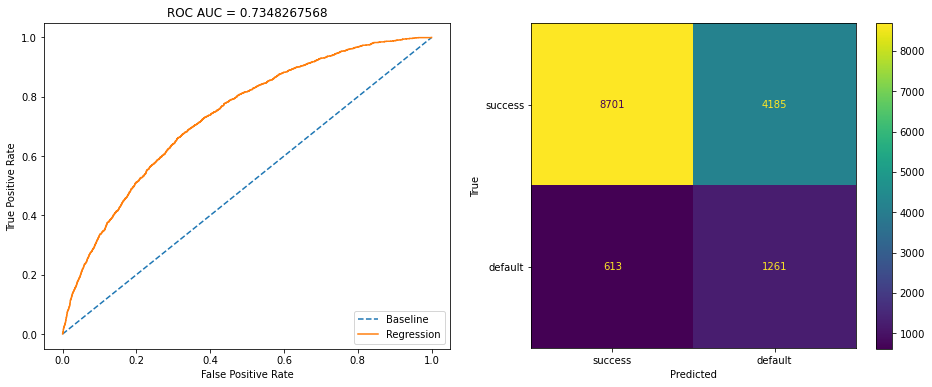

,estimator,roc_auc,accuracy,precision,recall,f1
0,base,0.732449,0.872358,0.454545,0.026681,0.050403
0,lr+gen,0.734772,0.872290,0.459259,0.033084,0.061722
0,lr+cv+f1,0.734757,0.872019,0.442748,0.030950,0.057855
0,lr+gen+cv+roc_auc+balance,0.734825,0.674864,0.231504,0.672892,0.344488
0,lr+gen+gs+roc_auc+f1,0.734827,0.674932,0.231546,0.672892,0.344536


In [85]:
# Model with generated features and LogisticRegressionCV с балансировкой
data = pd.read_csv(DATA_PATH + '/train.csv')
X_train, X_test, y_train, y_test = split(data)

scorer = ScorerGen(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))

grid_values = {
    'penalty': ['l2'], 
    'C': [0.01],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'class_weight': [None, 'balanced'],
}
model = LogisticRegression(max_iter=1000, random_state=42)
model_cv = GridSearchCV(model, grid_values, cv=5, n_jobs=-1, verbose=3, 
                        scoring=['f1', 'roc_auc'], refit='roc_auc')
model_cv.fit(scorer.prepare_fit_transform()[0], scorer.get_target())
print('Best params', model_cv.best_params_)
model = model_cv.best_estimator_

scorer.train(model)

y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('lr+gen+gs+roc_auc+f1', y_test, y_pred, y_prob)

In [86]:
#showImportance(model, scorer.prepare_fit_transform()[0].columns, n=20)

In [87]:
class ScorerSampler(ScorerGen):
    def __init__(self, X_train, y_train):
        super().__init__(X_train, y_train)
        self._sampler = None
    
    def prepare_fit_transform(self):
        assert(self._sampler is not None)
        (df, features)  = self.prepare(self._data, self._features)
        df = self.fit(df, features).transform(df, features)
        X_resampled, y_resampled = self._sampler.fit_resample(df, self._target)
        print(X_resampled.shape)
        return X_resampled, y_resampled

    def train(self, model):
        assert(self._sampler is not None)
        self._model = model
        assert(self._model is not None)
        (df, features) = self.prepare(self._data, self._features)
        df = self.fit(df, features).transform(df, features)
        X_resampled, y_resampled = self._sampler.fit_resample(df, self._target)
        print(X_resampled.shape)
        self._model.fit(X_resampled, y_resampled)
        return model

In [88]:
from imblearn import over_sampling, under_sampling
class ScorerOver(ScorerSampler):
    '''
    Класс для сэмплирования незбалансированных данных
    '''
    def __init__(self, X_train, y_train):
        super().__init__(X_train, y_train)
        self._sampler = over_sampling.RandomOverSampler(random_state=42)
#        self._sampler = over_sampling.SMOTE()
#        self._sampler = over_sampling.ADASYN()
        


(103082, 28)


,sex,car,car_type,foreign_passport,good_work,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,...,decline_app_cnt,bki_request_cnt,income,mean_income_age,mean_decline_age,mean_request_age,app_days,region_rating,first_time,sna
98298,0,1,0,0,0,0,0,0,1,0,...,1.080447,0.205159,-0.686434,-0.558329,0.920911,0.008114,0.718803,60,1,4
87898,0,0,0,1,0,0,1,0,0,0,...,-0.382794,-0.493122,-0.004571,-0.277354,-0.211691,-0.550379,-1.523831,80,3,4
13017,0,0,0,0,0,0,0,0,1,0,...,-0.382794,-1.191403,-1.055892,-0.660279,-0.302354,-0.942201,1.404053,80,1,1
62133,1,0,0,0,0,0,0,0,1,0,...,2.543688,-0.493122,-0.463060,-0.537995,2.232715,-0.538870,0.936837,50,1,4
15177,0,0,0,0,1,0,0,0,1,0,...,-0.382794,0.205159,-0.213767,-0.451052,-0.255509,-0.091814,-0.776286,40,4,2


(103082, 28)


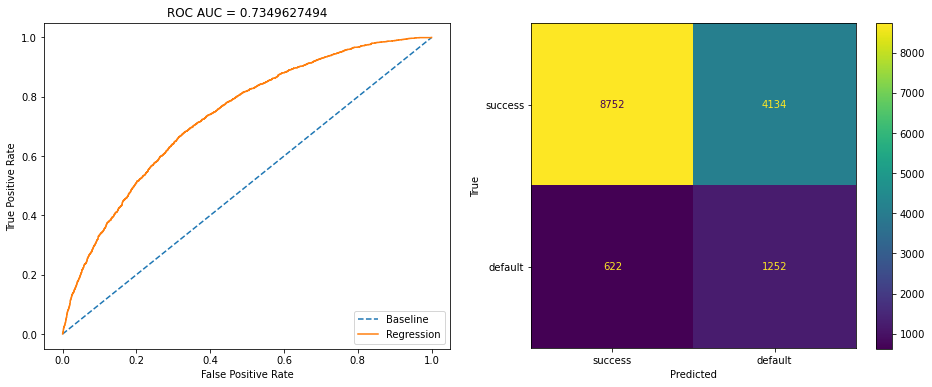

,estimator,roc_auc,accuracy,precision,recall,f1
0,base,0.732449,0.872358,0.454545,0.026681,0.050403
0,lr+gen,0.734772,0.872290,0.459259,0.033084,0.061722
0,lr+cv+f1,0.734757,0.872019,0.442748,0.030950,0.057855
0,lr+gen+cv+roc_auc+balance,0.734825,0.674864,0.231504,0.672892,0.344488
0,lr+gen+gs+roc_auc+f1,0.734827,0.674932,0.231546,0.672892,0.344536
0,lr+cv+roc_auc+oversamp,0.734963,0.677778,0.232455,0.668090,0.344904


In [89]:
# Model with generated features and LogisticRegressionCV and sampling
from sklearn.model_selection import StratifiedKFold
data = pd.read_csv(DATA_PATH + '/train.csv')
X_train, X_test, y_train, y_test = split(data)
#'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'
scorer = ScorerOver(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))
model = LogisticRegression(C=0.01, max_iter=1000, random_state=42, solver='saga')
model = scorer.train(model)
y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('lr+cv+roc_auc+oversamp', y_test, y_pred, y_prob)


In [90]:
from imblearn import over_sampling, under_sampling
class ScorerUnder(ScorerSampler):
    '''
    Класс для сэмплирования незбалансированных данных
    '''
    def __init__(self, X_train, y_train):
        super().__init__(X_train, y_train)
        self._sampler = under_sampling.RandomUnderSampler(random_state=42)
#        self._sampler = over_sampling.NearMiss(version=1)()



(14996, 28)


,sex,car,car_type,foreign_passport,good_work,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,...,decline_app_cnt,bki_request_cnt,income,mean_income_age,mean_decline_age,mean_request_age,app_days,region_rating,first_time,sna
10509,1,0,0,0,0,0,0,0,1,0,...,-0.382794,-1.191403,-0.004571,-0.319471,-0.272007,-0.547750,-0.776286,60,4,1
1656,0,1,0,1,1,0,1,0,0,0,...,-0.382794,-1.191403,1.327153,1.036128,-0.652902,-0.737088,0.376179,80,3,1
2084,1,1,1,1,1,0,1,0,0,0,...,-0.382794,-1.191403,2.093876,2.266901,-0.391640,-0.905457,-1.461535,70,3,2
2005,0,1,0,0,0,0,1,0,0,0,...,-0.382794,-0.493122,-0.271800,-0.368548,-0.342708,-0.453785,0.158145,40,3,1
12233,0,0,0,0,0,0,0,0,0,1,...,-0.382794,0.205159,0.838763,0.183963,-0.260248,0.415123,0.625360,70,2,1


(14996, 28)


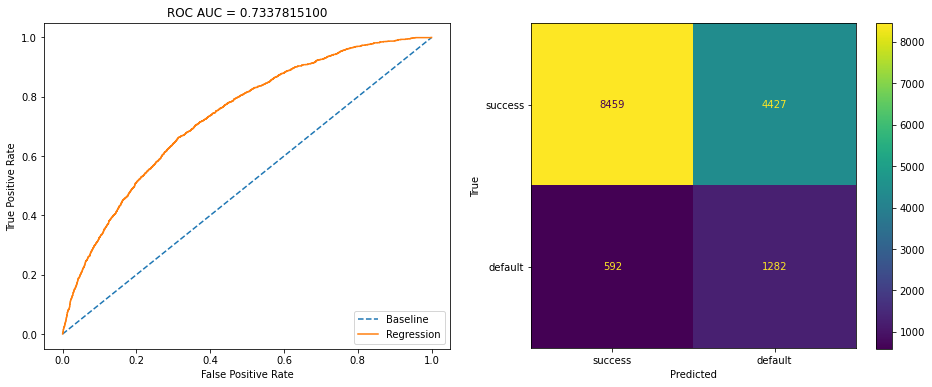

,estimator,roc_auc,accuracy,precision,recall,f1
0,base,0.732449,0.872358,0.454545,0.026681,0.050403
0,lr+gen,0.734772,0.872290,0.459259,0.033084,0.061722
0,lr+cv+f1,0.734757,0.872019,0.442748,0.030950,0.057855
0,lr+gen+cv+roc_auc+balance,0.734825,0.674864,0.231504,0.672892,0.344488
0,lr+gen+gs+roc_auc+f1,0.734827,0.674932,0.231546,0.672892,0.344536
0,lr+cv+roc_auc+oversamp,0.734963,0.677778,0.232455,0.668090,0.344904
0,lr+cv+roc_auc+undersamp,0.733782,0.659959,0.224558,0.684098,0.338125


In [91]:
# Model with generated features and LogisticRegressionCV and sampling
from sklearn.model_selection import StratifiedKFold
data = pd.read_csv(DATA_PATH + '/train.csv')
X_train, X_test, y_train, y_test = split(data)

scorer = ScorerUnder(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))
model = LogisticRegression(C=0.01, max_iter=1000, random_state=42, solver='saga')
model = scorer.train(model)
y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('lr+cv+roc_auc+undersamp', y_test, y_pred, y_prob)

(14996, 28)


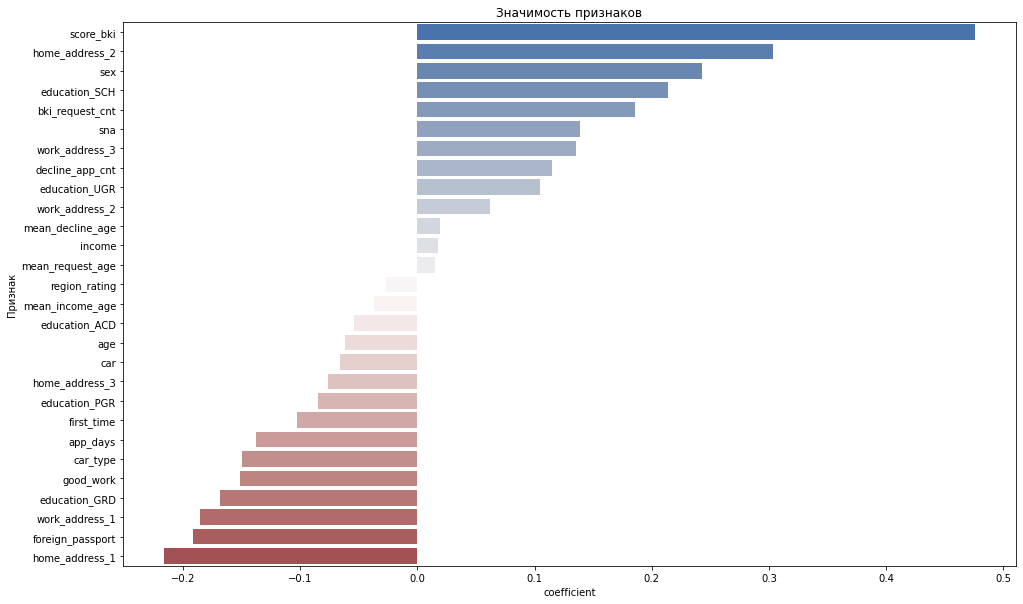

In [92]:
showImportance(model, scorer.prepare_fit_transform()[0].columns, n=20)

,sex,car,car_type,foreign_passport,good_work,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,...,decline_app_cnt,bki_request_cnt,income,mean_income_age,mean_decline_age,mean_request_age,app_days,region_rating,first_time,sna
56948,0,0,0,0,0,0,0,1,0,0,...,-0.382794,-1.191403,-0.607786,-0.360271,-0.499109,-0.843245,-0.184480,50,3,3
37334,0,0,0,0,1,0,0,0,1,0,...,-0.382794,-1.191403,-2.602713,-0.664570,-0.499109,-0.843245,0.220440,50,1,4
45972,0,0,0,0,0,0,0,0,1,0,...,5.470170,1.601721,-0.131297,-0.250412,7.032525,2.241195,0.563065,40,4,1
14822,0,1,1,0,0,0,0,0,1,0,...,1.080447,1.601721,-0.271800,-0.234611,0.762613,1.866445,-0.153332,50,3,1
8555,1,0,0,0,0,0,1,0,0,0,...,-0.382794,0.903440,0.216378,-0.243842,-0.327279,0.402242,1.622086,60,3,1


[18:11:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




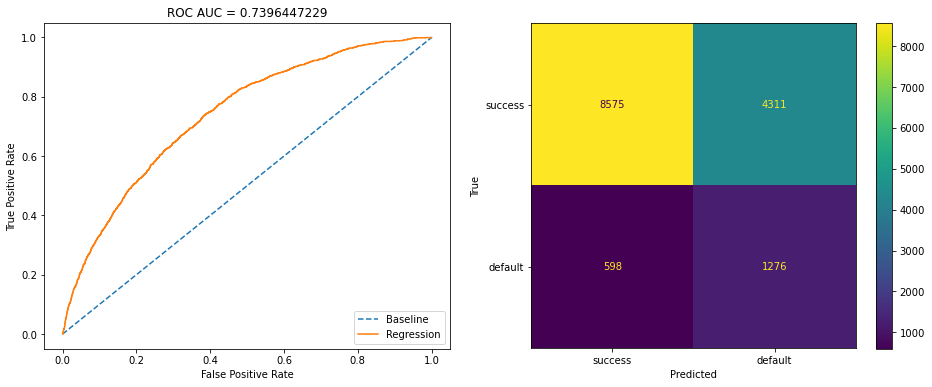

,estimator,roc_auc,accuracy,precision,recall,f1
0,base,0.732449,0.872358,0.454545,0.026681,0.050403
0,lr+gen,0.734772,0.872290,0.459259,0.033084,0.061722
0,lr+cv+f1,0.734757,0.872019,0.442748,0.030950,0.057855
0,lr+gen+cv+roc_auc+balance,0.734825,0.674864,0.231504,0.672892,0.344488
0,lr+gen+gs+roc_auc+f1,0.734827,0.674932,0.231546,0.672892,0.344536
0,lr+cv+roc_auc+oversamp,0.734963,0.677778,0.232455,0.668090,0.344904
0,lr+cv+roc_auc+undersamp,0.733782,0.659959,0.224558,0.684098,0.338125
0,xgb,0.739645,0.667412,0.228387,0.680896,0.342045


In [93]:
# Построение XGB модели c балансировкой
data = pd.read_csv(DATA_PATH + '/train.csv')
X_train, X_test, y_train, y_test = split(data)

scorer = ScorerGen(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))

sum_pos = sum(y_train)
sum_neg = len(y_train) - sum_pos
class_weights=[1, sum_neg / sum_pos]
model = XGBClassifier(random_state=42, subsample=0.8, reg_lambda=50, n_estimators=50, 
                      max_depth=3, learning_rate=0.2, colsample_bytree=0.5,
                      scale_pos_weight=sum_neg / sum_pos,
                      objective='binary:logistic', 
                      n_jobs=-1, use_label_encoder=False)
scorer.train(model)
y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('xgb', y_test, y_pred, y_prob)

,sex,car,car_type,foreign_passport,good_work,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,...,decline_app_cnt,bki_request_cnt,income,mean_income_age,mean_decline_age,mean_request_age,app_days,region_rating,first_time,sna
22815,1,1,0,0,0,0,0,0,0,1,...,-0.382794,0.903440,0.216378,0.058024,-0.652902,0.604080,-0.527105,70,1,4
2105,1,1,1,0,0,0,0,0,1,0,...,-0.382794,-1.191403,1.606676,1.202024,-0.272007,-0.547750,-1.461535,60,4,1
73132,0,0,0,0,0,0,0,0,1,0,...,-0.382794,-0.493122,-2.602713,-0.781525,-0.342708,-0.453785,-0.215628,50,1,4
65012,0,1,1,1,1,0,0,0,0,1,...,-0.382794,0.903440,1.059511,0.495968,-0.403039,0.451876,0.905689,80,3,1
72599,0,0,0,0,0,0,0,0,0,1,...,4.006929,1.601721,-0.104934,0.088940,3.579428,4.886395,-0.340218,50,2,2


0:	total: 65.9ms	remaining: 19.7s
100:	total: 1.17s	remaining: 2.31s
200:	total: 2.09s	remaining: 1.03s
299:	total: 3.07s	remaining: 0us


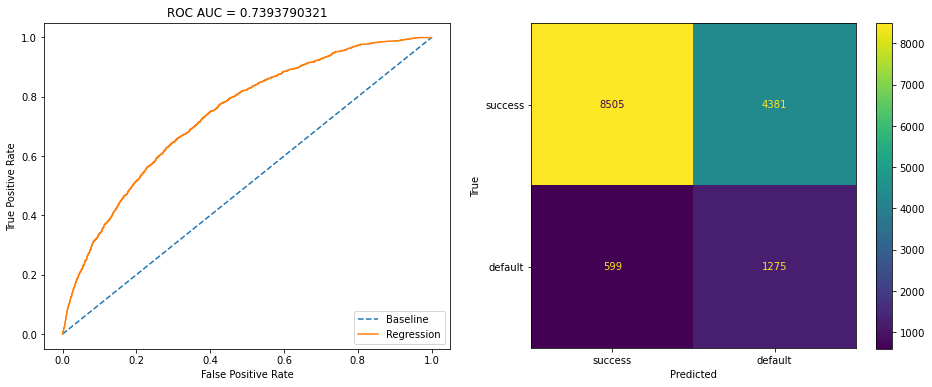

,estimator,roc_auc,accuracy,precision,recall,f1
0,base,0.732449,0.872358,0.454545,0.026681,0.050403
0,lr+gen,0.734772,0.872290,0.459259,0.033084,0.061722
0,lr+cv+f1,0.734757,0.872019,0.442748,0.030950,0.057855
0,lr+gen+cv+roc_auc+balance,0.734825,0.674864,0.231504,0.672892,0.344488
0,lr+gen+gs+roc_auc+f1,0.734827,0.674932,0.231546,0.672892,0.344536
0,lr+cv+roc_auc+oversamp,0.734963,0.677778,0.232455,0.668090,0.344904
0,lr+cv+roc_auc+undersamp,0.733782,0.659959,0.224558,0.684098,0.338125
0,xgb,0.739645,0.667412,0.228387,0.680896,0.342045
0,catboost,0.739379,0.662602,0.225424,0.680363,0.338645


In [94]:
data = pd.read_csv(DATA_PATH + '/train.csv')
X_train, X_test, y_train, y_test = split(data)

# Построение CatBoost модели c балансировкой

scorer = ScorerGen(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))

sum_pos = sum(y_train)
sum_neg = len(y_train) - sum_pos
class_weights=[1, sum_neg / sum_pos]
model = CatBoostClassifier(iterations=300,
                           metric_period=100,
                           random_seed=42,
                           depth=3,
                           l2_leaf_reg=8,
                           eval_metric='AUC',
                           early_stopping_rounds=10,
                           learning_rate=0.05,
                           class_weights=class_weights
                          )

scorer.train(model)
y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('catboost', y_test, y_pred, y_prob)


,sex,car,car_type,foreign_passport,good_work,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,...,decline_app_cnt,bki_request_cnt,income,mean_income_age,mean_decline_age,mean_request_age,app_days,region_rating,first_time,sna
31734,0,0,0,0,0,0,1,0,0,0,...,-0.382794,-1.191403,-1.717230,-0.485367,-0.652902,-0.737088,-1.243501,50,1,4
48580,0,0,0,1,0,0,0,0,0,1,...,-0.382794,0.205159,-1.055892,-0.376689,-0.652902,0.157024,0.313883,60,3,1
33396,0,0,0,0,0,0,1,0,0,0,...,-0.382794,0.205159,0.404152,-0.060552,-0.263668,-0.149682,-0.745138,80,3,1
9098,0,0,0,0,0,0,1,0,0,0,...,-0.382794,0.903440,1.210034,0.712914,-0.241061,0.344377,1.372905,80,3,4
726,0,1,1,0,0,0,0,0,1,0,...,1.080447,0.903440,-0.004571,-0.234258,0.831521,0.482671,-0.682843,70,1,2


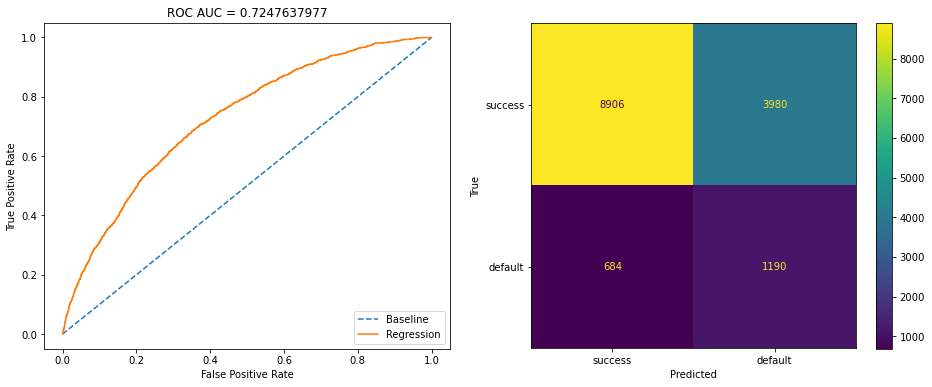

,estimator,roc_auc,accuracy,precision,recall,f1
0,base,0.732449,0.872358,0.454545,0.026681,0.050403
0,lr+gen,0.734772,0.872290,0.459259,0.033084,0.061722
0,lr+cv+f1,0.734757,0.872019,0.442748,0.030950,0.057855
0,lr+gen+cv+roc_auc+balance,0.734825,0.674864,0.231504,0.672892,0.344488
0,lr+gen+gs+roc_auc+f1,0.734827,0.674932,0.231546,0.672892,0.344536
0,lr+cv+roc_auc+oversamp,0.734963,0.677778,0.232455,0.668090,0.344904
0,lr+cv+roc_auc+undersamp,0.733782,0.659959,0.224558,0.684098,0.338125
0,xgb,0.739645,0.667412,0.228387,0.680896,0.342045
0,catboost,0.739379,0.662602,0.225424,0.680363,0.338645
0,rf+balanced,0.724764,0.684011,0.230174,0.635005,0.337876


In [95]:
data = pd.read_csv(DATA_PATH + '/train.csv')
X_train, X_test, y_train, y_test = split(data)

# Построение RandomForest модели c балансировкой
scorer = ScorerGen(X_train, y_train)
display(scorer.prepare_fit_transform()[0].sample(5))

model = RandomForestClassifier(n_estimators=100, max_depth=5,
                               class_weight='balanced', random_state=42)

scorer.train(model)
y_prob = scorer.predict_proba(X_test)
base_roc_auc = roc_auc_score(y_test, y_prob)
y_pred = scorer.predict(X_test)
_ = showMetrics(y_test, y_prob, y_pred)
ScorerHistory.add2scores('rf+balanced', y_test, y_pred, y_prob)


In [96]:
############################################
# Выбор модели
ScorerHistory.scores_df.sort_values('roc_auc', ascending=False)

,estimator,roc_auc,accuracy,precision,recall,f1
0,xgb,0.739645,0.667412,0.228387,0.680896,0.342045
0,catboost,0.739379,0.662602,0.225424,0.680363,0.338645
0,lr+cv+roc_auc+oversamp,0.734963,0.677778,0.232455,0.668090,0.344904
0,lr+gen+gs+roc_auc+f1,0.734827,0.674932,0.231546,0.672892,0.344536
0,lr+gen+cv+roc_auc+balance,0.734825,0.674864,0.231504,0.672892,0.344488
0,lr+gen,0.734772,0.872290,0.459259,0.033084,0.061722
0,lr+cv+f1,0.734757,0.872019,0.442748,0.030950,0.057855
0,lr+cv+roc_auc+undersamp,0.733782,0.659959,0.224558,0.684098,0.338125
0,base,0.732449,0.872358,0.454545,0.026681,0.050403
0,rf+balanced,0.724764,0.684011,0.230174,0.635005,0.337876


In [97]:
# Похоже из рассмотренных классификаторов оптимален catboost+gen+roc_auc
# но выбираем: LogisticRegression так как xgd и catboost похоже переобучились
model = LogisticRegression(C=0.01, max_iter=1000, penalty='l2', solver='saga', class_weight='balanced')
sum_pos = sum(y_train)
sum_neg = len(y_train) - sum_pos
class_weights=[1, sum_neg / sum_pos]
model = CatBoostClassifier(iterations=300,
                           metric_period=100,
                           depth=3,
                           l2_leaf_reg=6,
                           eval_metric='AUC',
                           early_stopping_rounds=10,
                           learning_rate=0.05,
                           class_weights=class_weights
                          )


In [98]:
train = pd.read_csv(DATA_PATH + '/train.csv')
test = pd.read_csv(DATA_PATH + '/test.csv')
X_train = train.drop('default', axis=1)
y_train = train['default']
X_test = test

sum_pos = sum(y_train)
sum_neg = len(y_train) - sum_pos
class_weights=[1, sum_neg / sum_pos]
model = CatBoostClassifier(iterations=300,
                           metric_period=100,
                           random_seed=42,
                           depth=3,
                           l2_leaf_reg=8,
                           eval_metric='AUC',
                           early_stopping_rounds=10,
                           learning_rate=0.05,
                           class_weights=class_weights
                          )

scorer = ScorerGen(X_train, y_train)
model = scorer.train(model)
y_prob = scorer.predict_proba(X_test)
sample_submission = X_test[['client_id']].copy()
sample_submission['default'] = y_prob
sample_submission.head()

0:	total: 12.8ms	remaining: 3.82s
100:	total: 1.06s	remaining: 2.08s
200:	total: 2.09s	remaining: 1.03s
299:	total: 3.21s	remaining: 0us


,client_id,default
0,74835,0.205285
1,17527,0.730109
2,75683,0.368563
3,26883,0.351532
4,28862,0.088433


In [99]:
sample_submission.to_csv('submission_cb.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0.205285
1,17527,0.730109
2,75683,0.368563
3,26883,0.351532
4,28862,0.088433
5,99881,0.635708
6,26630,0.760999
7,79934,0.269101
8,16605,0.158308
9,105449,0.166511


## Выводы:
Рассмотренные модели дают примерно одинаковый ROC-AUC (0.73+-).
Модели с балансировкой классов дают в разы больший F1.
Наверное, настройкой гиперпараметров XGD и CatBoost можно добиться улучшения результата, но зато с
логистической регрессией работать проще (меньше гиперпараметров).
Можно сгенерировать еще признаки (например полиномиальные), но тогда значитльно упадет интерпретируемость модели.

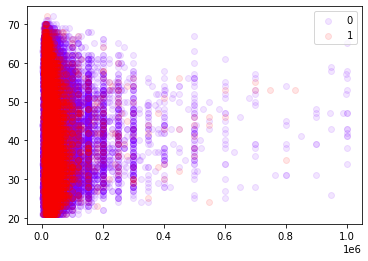

In [100]:
import matplotlib.cm as cm # импортируем цветовые схемы, чтобы рисовать графики.
train = pd.read_csv(DATA_PATH + '/train.csv')
colors = cm.rainbow(np.linspace(0, 1, len(set(train['default']))))
incom_age = train[['income', 'age']].to_numpy()
for y, c in zip(set(train['default']), colors):
    plt.scatter(incom_age[train['default'].values==y, 0], 
                incom_age[train['default'].values==y, 1], 
                c=c.reshape(1,-1), alpha=0.1, label=str(y))
plt.legend()